In [1]:
import pandas as pd
import numpy as np
from random import shuffle
from osgeo import ogr, osr
from sentinelhub import WmsRequest, WcsRequest, MimeType, CRS, BBox, constants
from s2cloudless import S2PixelCloudDetector, CloudMaskRequest
import logging
from collections import Counter
import datetime
import os
import yaml
from sentinelhub import DataSource
import scipy.sparse as sparse
import scipy
from scipy.sparse.linalg import splu
from skimage.transform import resize
from sentinelhub import CustomUrlParam
from time import time as timer
import multiprocessing

/Users/john.brandt/anaconda3/envs/remote_sensing/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
%run ../src/slope.py
%run ../src/utils-bilinear.py
%run ../src/dsen2/utils/DSen2Net.py
#!source ~/.bash_profile

Instructions for updating:
Colocations handled automatically by placer.


Using TensorFlow backend.


In [3]:
dates = ('2018-12-15', '2020-01-15')
SIZE = 9
IMSIZE = (SIZE * 14)+2

cloud_detector = S2PixelCloudDetector(threshold=0.4, average_over=4, dilation_size=2)

# Helper functions (to be moved to a utils file)

In [4]:
EPSG = CRS.WGS84
GRID_SIZE_X = 1
GRID_SIZE_Y = 1

IMAGE_X = 14*GRID_SIZE_X
IMAGE_Y = 14*GRID_SIZE_Y

TEST_X = 5
TEST_Y = 5

with open("../config.yaml", 'r') as stream:
    key = (yaml.safe_load(stream))
    API_KEY = key['key']

In [5]:
c_arr = np.array([[1, 1, 1, 1, 1,],
                  [1, 2, 2, 2, 1,],
                  [1, 2, 3, 2, 1,],
                  [1, 2, 2, 2, 1,],
                  [1, 1, 1, 1, 1,],])
                  
c_arr = c_arr / 3
o_arr = 1 - c_arr
c_arr = np.tile(c_arr[:, :, np.newaxis], (1, 1, 11))
o_arr = np.tile(o_arr[:, :, np.newaxis], (1, 1, 11))

def convertCoords(xy, src='', targ=''):

    srcproj = osr.SpatialReference()
    srcproj.ImportFromEPSG(src)
    targproj = osr.SpatialReference()
    if isinstance(targ, str):
        targproj.ImportFromProj4(targ)
    else:
        targproj.ImportFromEPSG(targ)
    transform = osr.CoordinateTransformation(srcproj, targproj)

    pt = ogr.Geometry(ogr.wkbPoint)
    pt.AddPoint(xy[0], xy[1])
    pt.Transform(transform)
    return([pt.GetX(), pt.GetY()])

def bounding_box(point, x_offset_max = 140, y_offset_max = 140, expansion = 10):
    # LONG, LAT FOR SOME REASON
    #@valid
    tl = point
    
    if 102 <= tl[0] <= 109:
        epsg = 32648 if tl[1] > 0 else 32748
    if 96 <= tl[0] <= 102:
        epsg = 32647 if tl[1] > 0 else 32747
    if 90 <= tl[0] <= 96:
        epsg = 32646 if tl[1] > 0 else 32746
    if 84 <= tl[0] <= 90:
        epsg = 32645 if tl[1] > 0 else 32745
    if 78 <= tl[0] <= 84:
        epsg = 32644 if tl[1] > 0 else 32744
    if 72 <= tl[0] <= 78:
        epsg = 32643 if tl[1] > 0 else 32743
    if 66 <= tl[0] <= 72:
        epsg = 32642 if tl[1] > 0 else 32742
    if 60 <= tl[0] <= 66:
        epsg = 32641 if tl[1] > 0 else 32741
    if 54 <= tl[0] <= 60:
        epsg = 32640 if tl[1] > 0 else 32740
    if 48 <= tl[0] <= 54:
        epsg = 32639 if tl[1] > 0 else 32739
    if 42 <= tl[0] <= 48:
        epsg = 32638 if tl[1] > 0 else 32738
    if 36 <= tl[0] <= 42:
        epsg = 32637 if tl[1] > 0 else 32737
    if 30 <= tl[0] <= 36:
        epsg = 32636 if tl[1] > 0 else 32736
    if 24 <= tl[0] <= 30:
        epsg = 32635 if tl[1] > 0 else 32735
    if 18 <= tl[0] <= 24:
        epsg = 32634 if tl[1] > 0 else 32734
    if 12 <= tl[0] <= 18:
        epsg = 32633 if tl[1] > 0 else 32733
    if 6 <= tl[0] <= 12:
        epsg = 32632 if tl[1] > 0 else 32732
    if 0 <= tl[0] <= 6:
        epsg = 32631 if tl[1] > 0 else 32731
    if -6 <= tl[0] <= 0:
        epsg = 32630 if tl[1] > 0 else 32730
    if -12 <= tl[0] <= -6:
        epsg = 32629 if tl[1] > 0 else 32729
    if -18 <= tl[0] <= -12:
        epsg = 32628 if tl[1] > 0 else 32728
    if -24 <= tl[0] <= -18:
        epsg = 32627 if tl[1] > 0 else 32727
    if -30 <= tl[0] <= -24:
        epsg = 32626 if tl[1] > 0 else 32726
    if -36 <= tl[0] <= -30:
        epsg = 32625 if tl[1] > 0 else 32725
    if -42 <= tl[0] <= -36:
        epsg = 32624 if tl[1] > 0 else 32724
    if -48 <= tl[0] <= -42:
        epsg = 32623 if tl[1] > 0 else 32723
    if -54 <= tl[0] <= -48:
        epsg = 32622 if tl[1] > 0 else 32722
    if -60 <= tl[0] <= -54:
        epsg = 32621 if tl[1] > 0 else 32721
    if -66 <= tl[0] <= -60:
        epsg = 32620 if tl[1] > 0 else 32720
    if -72 <= tl[0] <= -66:
        epsg = 32619 if tl[1] > 0 else 32719
    if -78 <= tl[0] <= -72:
        epsg = 32618 if tl[1] > 0 else 32718
    if -84 <= tl[0] <= -78:
        epsg = 32617 if tl[1] > 0 else 32717
    if -90 <= tl[0] <= -84:
        epsg = 32616 if tl[1] > 0 else 32716
    if -96 <= tl[0] <= -90:
        epsg = 32615 if tl[1] > 0 else 32715
    if -102 <= tl[0] <= -96:
        epsg = 32614 if tl[1] > 0 else 32714
    if -108 <= tl[0] <= -102:
        epsg = 32613 if tl[1] > 0 else 32713
    if -114 <= tl[0] <= -108:
        epsg = 32612 if tl[1] > 0 else 32712
    if -120 <= tl[0] <= -114:
        epsg = 32611 if tl[1] > 0 else 32711
    if -126 <= tl[0] <= -120:
        epsg = 32610 if tl[1] > 0 else 32710
        
    tl = convertCoords(tl, 4326, epsg)
    
    br = (tl[0], tl[1])
    tl = ((tl[0] + (x_offset_max)), (tl[1] + (y_offset_max )))
    distance1 = tl[0] - br[0]
    distance2 = tl[1] - br[1]
    
    br = [a - expansion for a in br]
    tl = [a + expansion for a in tl]
    
    after = [b - a for a,b in zip(br, tl)]
    br = convertCoords(br, epsg, 4326)
    tl = convertCoords(tl, epsg, 4326)
    
    min_x = tl[0] # original X offset - 10 meters
    max_x = br[0] # original X offset + 10*GRID_SIZE meters
    
    min_y = tl[1] # original Y offset - 10 meters
    max_y = br[1] # original Y offset + 10 meters + 140 meters
    return [(min_x, min_y), (max_x, max_y)]
 

# Data download

In [6]:
def identify_clouds(bbox, epsg = EPSG, dates = dates):
    try:
        box = BBox(bbox, crs = epsg)
        cloud_request = WmsRequest(
            layer='CLOUD_DETECTION',
            bbox=box,
            time=dates,
            width=(SIZE*14)+2,
            height=(SIZE*14)+2,
            image_format = MimeType.TIFF_d32f,
            maxcc=0.75,
            instance_id=API_KEY,
            custom_url_params = {constants.CustomUrlParam.UPSAMPLING: 'NEAREST'},
            time_difference=datetime.timedelta(hours=24),
        )
        
        cloud_img = cloud_request.get_data()
        cloud_probs = cloud_detector.get_cloud_probability_maps(np.array(cloud_img))
        means = np.mean(cloud_probs, (1, 2))
        clean_steps = [i for i, val in enumerate(means) if val < 0.20]
        return clean_steps, means, cloud_probs
    except Exception as e:
        logging.fatal(e, exc_info=True)
    
    
def download_dem(bbox, epsg = EPSG):
    #@valid
    box = BBox(bbox, crs = epsg)
    dem_s = (SIZE*14)+4
    dem_request = WmsRequest(data_source=DataSource.DEM,
                         layer='DEM',
                         bbox=box,
                         width=dem_s,
                         height=dem_s,
                         instance_id=API_KEY,
                         image_format=MimeType.TIFF_d32f,
                         custom_url_params={CustomUrlParam.SHOWLOGO: False})
    dem_image = dem_request.get_data()[0]
    dem_image = calcSlope(dem_image.reshape((1, dem_s, dem_s)),
                  np.full((dem_s, dem_s), 10), np.full((dem_s, dem_s), 10), zScale = 1, minSlope = 0.02)
    dem_image = dem_image.reshape((dem_s,dem_s, 1))
    dem_image = dem_image[1:dem_s-1, 1:dem_s-1, :]
    return dem_image #/ np.max(dem_image)

def download_layer(bbox, epsg = EPSG, dates = dates):
    try:
        box = BBox(bbox, crs = epsg)
        image_request = WcsRequest(
                layer='L2A20',
                bbox=box,
                time=dates,
                image_format = MimeType.TIFF_d32f,
                maxcc=0.75,
                resx='10m', resy='10m',
                instance_id=API_KEY,
                custom_url_params = {constants.CustomUrlParam.DOWNSAMPLING: 'NEAREST',
                                    constants.CustomUrlParam.UPSAMPLING: 'NEAREST'},
                time_difference=datetime.timedelta(hours=24),
            )
        img_bands = image_request.get_data()
        img_20 = np.stack(img_bands)
        print("Original size: {}".format(img_20.shape))
        img_20 = resize(img_20, (img_20.shape[0], IMSIZE, IMSIZE, img_20.shape[-1]), order = 0)
        
        image_request = WcsRequest(
                layer='L2A10',
                bbox=box,
                time=dates,
                image_format = MimeType.TIFF_d32f,
                maxcc=0.75,
                resx='10m', resy='10m',
                instance_id=API_KEY,
                custom_url_params = {constants.CustomUrlParam.DOWNSAMPLING: 'BICUBIC',
                                    constants.CustomUrlParam.UPSAMPLING: 'BICUBIC'},
                time_difference=datetime.timedelta(hours=24),
        )
        
        img_bands = image_request.get_data()
        img_10 = np.stack(img_bands)
        print("Original 10 size: {}".format(img_10.shape))
        img_10 = resize(img_10, (img_10.shape[0], IMSIZE, IMSIZE, img_10.shape[-1]), order = 0)
        shadows = img_10[:, :, :, -1]
        img_10 = img_10[:, :, :, :-1]
        
        shadows[np.where(shadows != 3)] = 0
        shadows[np.where(shadows == 3)] = 1
        print("Data shape: {}".format(shadows.shape))
        shadow_sum = np.sum(shadows, axis = (1, 2))
        shadow_steps = np.argwhere(shadow_sum > (IMSIZE*IMSIZE) / 4)
        
        img = np.concatenate([img_10, img_20], axis = -1)
        return img, image_request, shadows, shadow_steps

    except Exception as e:
        logging.fatal(e, exc_info=True)
        
        
        
def download_sentinel_1(bbox, epsg = EPSG, dates = dates, layer = "SENT", year = 2019):
    try:
        box = BBox(bbox, crs = epsg)
        image_request = WcsRequest(
                layer=layer,
                bbox=box,
                time=dates,
                image_format = MimeType.TIFF_d32f,
                maxcc=1.0,
                resx='5m', resy='5m',
                instance_id=API_KEY,
                custom_url_params = {constants.CustomUrlParam.DOWNSAMPLING: 'NEAREST',
                                    constants.CustomUrlParam.UPSAMPLING: 'NEAREST'},
                time_difference=datetime.timedelta(hours=24),
            )
        img_bands = image_request.get_data()
        s1 = np.stack(img_bands)
        s1 = resize(s1, (s1.shape[0], IMSIZE*2, IMSIZE*2, s1.shape[-1]), order = 0)
        s1 = np.reshape(s1, (s1.shape[0], s1.shape[1]//2, 2, s1.shape[2] // 2, 2, s1.shape[-1]))
        s1 = np.mean(s1, (2, 4))
        #s1 = s1[:, 8:24, 8:24, :]
        
        image_dates = []
        for date in image_request.get_dates():
            if date.year == year - 1:
                image_dates.append(-365 + starting_days[(date.month-1)] + date.day)
            if date.year == year:
                image_dates.append(starting_days[(date.month-1)] + date.day)
            if date.year == year + 1:
                image_dates.append(365 + starting_days[(date.month-1)]+date.day)
        image_dates = np.array(image_dates)
        to_remove = np.argwhere(np.max(s1, (1, 2, 3)) == 1.).flatten()
        s1 = np.delete(s1, to_remove, 0)
        #print(np.max(s1, (1, 2, 3)))
        image_dates = np.delete(image_dates, to_remove)
        return s1, image_dates

    except Exception as e:
        logging.fatal(e, exc_info=True)

# Cloud and shadow removal

In [7]:
def remove_cloud_and_shadows(tiles, c_probs, shadows, image_dates):
    wsize = 5
    c_probs = c_probs - np.min(c_probs, axis = 0)
    c_probs[np.where(c_probs > 0.33)] = 1.
    c_probs[np.where(c_probs < 0.33)] = 0.
    c_probs = np.reshape(c_probs, (c_probs.shape[0], 16, 8, 16, 8))
    c_probs = np.sum(c_probs, (2, 4))
    c_probs = resize(c_probs, (c_probs.shape[0], IMSIZE, IMSIZE), 0)
    c_probs[np.where(c_probs < 16)] = 0
    c_probs[np.where(c_probs >= 16)] = 1
    secondary_c_probs = np.copy(c_probs)
    c_probs += shadows
    c_probs[np.where(c_probs >= 1.)] = 1.
    number_interpolated = 0
    for cval in range(0, IMSIZE - 4, 1):
        for rval in range(0, IMSIZE - 4, 1):
            subs = c_probs[:, cval:cval + wsize, rval:rval+wsize]
            sums = np.sum(subs, axis = (1, 2))
            satisfactory = [x for x in range(c_probs.shape[0]) if sums[x] < 12]
            satisfactory = np.array(satisfactory)
            for date in range(0, tiles.shape[0]):
                if np.sum(subs[date, :, :]) > 12:
                    number_interpolated += 1
                    before, after = calculate_proximal_steps(date, satisfactory)
                    before = date + before
                    after = date + after
                    bef = tiles[before, cval:cval+wsize, rval:rval+wsize, : ]
                    aft = tiles[after, cval:cval+wsize, rval:rval+wsize, : ]
                    before = image_dates[before]
                    after = image_dates[after]
                    before_diff = abs(image_dates[date] - before)
                    after_diff = abs(image_dates[date] - after)
                    bef_wt = 1 - before_diff / (before_diff + after_diff)
                    aft_wt = 1 - bef_wt
                    candidate = bef_wt*bef + aft_wt*aft
                    candidate = candidate*c_arr + tiles[date, cval:cval+wsize, rval:rval+wsize, : ]*o_arr
                    tiles[date, cval:cval+wsize, rval:rval+wsize, : ] = candidate 
    print("A total of {} pixels were interpolated".format(number_interpolated))
    return tiles, c_probs, secondary_c_probs

def remove_missed_clouds(img):
    iqr = np.percentile(img[:, :, :, 3].flatten(), 75) - np.percentile(img[:, :, :, 3].flatten(), 25)
    thresh_t = np.percentile(img[:, :, :, 3].flatten(), 75) + iqr*2
    thresh_b = np.percentile(img[:, :, :, 3].flatten(), 25) - iqr*2
    diffs_fw = np.diff(img, 1, axis = 0)
    diffs_fw = np.mean(diffs_fw, axis = (1, 2, 3))
    diffs_fw = np.array([0] + list(diffs_fw))
    diffs_bw = np.diff(np.flip(img, 0), 1, axis = 0)
    diffs_bw = np.flip(np.mean(diffs_bw, axis = (1, 2, 3)))
    diffs_bw = np.array(list(diffs_bw) + [0])
    diffs = abs(diffs_fw - diffs_bw) * 100 # 3, -3 -> 6, -3, 3 -> 6, -3, -3
    #diffs = [int(x) for x in diffs]
    outlier_percs = []
    for step in range(img.shape[0]):
        bottom = len(np.argwhere(img[step, :, :, 3].flatten() > thresh_t))
        top = len(np.argwhere(img[step, :, :, 3].flatten() < thresh_b))
        p = 100* ((bottom + top) / (IMSIZE*IMSIZE))
        outlier_percs.append(p)
    to_remove = np.argwhere(np.array(outlier_percs) > 20)
    return to_remove

def threshold_shadows(arr):
    arr = np.copy(arr)
    iqr = np.percentile(arr.flatten(), 75) - np.percentile(arr.flatten(), 25)
    low = np.percentile(arr.flatten(), 25)
    #high = np.percentile(arr.flatten(), 75)
    thresh_low = low - 1.5*iqr
    #thresh_high = high + 2*iqr
    #arr[np.where(arr > thresh_high)] = 1.
    arr[np.where(arr < thresh_low)] = 1.
    arr[np.where(arr < 1)] = 0.
    arr = np.reshape(arr, (arr.shape[0], 16, 8, 16, 8))
    arr = np.sum(arr, axis = (2, 4))
    arr = resize(arr, (arr.shape[0], 128, 128), 0)
    fake_shadows = np.zeros((arr.shape[0], arr.shape[1], arr.shape[2]))
    for step in range(arr.shape[0]):
        if step > 0:
            for x in range(arr.shape[1]):
                for y in range(arr.shape[2]):
                    if arr[step, x, y] > 0:
                        before = arr[step - 1, x, y]
                        if abs(before - arr[step, x, y]) <= 20:
                            fake_shadows[step, x, y] = 1
                            
    for step in range(arr.shape[0]):
        if step < arr.shape[0] - 1:
            for x in range(arr.shape[1]):
                for y in range(arr.shape[2]):
                    if arr[step, x, y] > 0:
                        after = arr[step + 1, x, y]
                        if abs(after - arr[step, x, y]) <= 20:
                            fake_shadows[step, x, y] = 1
    before = np.sum(arr)
    arr[np.where(fake_shadows == 1)] = 0.
    after = np.sum(arr)
    arr[np.where(arr > 9)] = 1.
    arr[np.where(arr < 9)] = 0.
    print("Removed {} fake shadows, leaving {}".format(before - after, after))
    print("The total percent shadow cover is: {}%".format(after/(arr.shape[0]*arr.shape[1]*arr.shape[2])))
    for step in range(arr.shape[0]):
        for x in range(1, arr.shape[1] -1):
            for y in range(1, arr.shape[2] - 1):
                if np.sum(arr[step, x-1:x+2, y-1:y+2]) == 1:
                    if arr[step, x, y] != 0:
                        print("Removing: {} {} {} {}".format(step, x, y, np.sum(arr[step, x-1:x+2, y-1:y+2])))
                        arr[step, x, y] = 0
    
    return arr

# Data interpolation

In [8]:
diagonals = np.zeros(2*2+1)
diagonals[2] = 1.
for i in range(2):
    diff = diagonals[:-1] - diagonals[1:]
    diagonals = diff
offsets = np.arange(2+1)
shape = (70, 72)

def smooth(y, lmbd = 800, diagonals = diagonals, offsets = offsets, shape = shape, d = 2):
    E = sparse.eye(72, format = 'csc')
    D = scipy.sparse.diags(diagonals, offsets, shape)
    coefmat = E + lmbd * D.conj().T.dot(D)
    z = splu(coefmat).solve(y)
    return z

def calculate_and_save_best_images(img_bands, image_dates):

    biweekly_dates = [day for day in range(0, 360, 5)] # ideal imagery dates are every 15 days
    
    # Identify the dates where there is < 20% cloud cover
    #satisfactory_ids = list(np.argwhere(np.array(means) < 4.).reshape(-1, )) 
    satisfactory_ids = [x for x in range(0, img_bands.shape[0])]
    satisfactory_dates = [value for idx, value in enumerate(image_dates) if idx in satisfactory_ids]
    
    
    selected_images = {}
    for i in biweekly_dates:
        distances = [abs(date - i) for date in satisfactory_dates]
        closest = np.min(distances)
        closest_id = np.argmin(distances)
        # If there is imagery within 8 days, select it
        if closest < 8:
            date = satisfactory_dates[closest_id]
            image_idx = int(np.argwhere(np.array(image_dates) == date)[0])
            selected_images[i] = {'image_date': [date], 'image_ratio': [1], 'image_idx': [image_idx]}
        # If there is not imagery within 8 days, look for the closest above and below imagery
        else:
            distances = np.array([(date - i) for date in satisfactory_dates])
            # Number of days above and below the selected date of the nearest clean imagery
            above = distances[np.where(distances < 0, distances, -np.inf).argmax()]
            below = distances[np.where(distances > 0, distances, np.inf).argmin()]
            if abs(above) > 240: # If date is the last date, occassionally argmax would set above to - number
                above = below
            if abs(below) > 240:
                below = above
            if above != below:
                below_ratio = above / (above - below)
                above_ratio = 1 - below_ratio
            else:
                above_ratio = below_ratio = 0.5
                
            # Extract the image date and imagery index for the above and below values
            above_date = i + above
            above_image_idx = int(np.argwhere(np.array(image_dates) == above_date)[0])
            
            below_date = i + below
            below_image_idx = int(np.argwhere(np.array(image_dates) == below_date)[0])
            
            selected_images[i] = {'image_date': [above_date, below_date], 'image_ratio': [above_ratio, below_ratio],
                                 'image_idx': [above_image_idx, below_image_idx]}
                            
    max_distance = 0
    
    for i in selected_images.keys():
        #print(i, selected_images[i])
        if len(selected_images[i]['image_date']) == 2:
            dist = selected_images[i]['image_date'][1] - selected_images[i]['image_date'][0]
            if dist > max_distance:
                max_distance = dist
    
    print("Maximum time distance: {}".format(max_distance))
        
    keep_steps = []
    for i in selected_images.keys():
        info = selected_images[i]
        if len(info['image_idx']) == 1:
            step = img_bands[info['image_idx'][0]]
        if len(info['image_idx']) == 2:
            step1 = img_bands[info['image_idx'][0]] * 0.5#info['image_ratio'][0]
            step2 = img_bands[info['image_idx'][1]] * 0.5 #info['image_ratio'][1]
            step = step1 + step2
        keep_steps.append(step)
        
    keep_steps = np.stack(keep_steps)
    return keep_steps



# Tiling and coordinate selection functions

In [9]:
#coords = (13.540810, 38.177220) # tigray
#coords = (-1.817109, 37.477563) # makueni-2
#coords = (-2.575694, 37.949516) # makueni-3
#coords = (-2.561161, 38.096274) # makueni
#coords = (9.259359, -0.833750) # ghana
#coords = (-1.515869, 29.952997) # rwanda - useable
#coords = (-1.455224, 30.323259) # rwanda2
#coords = (13.316919, 2.581680) # niger
#coords = (13.18158333, 2.47805556) # niger - koure salima
#coords = (10.596, 14.2722) # cameroon
#coords = (18.232495, -92.134215) # campeche
#coords = (14.231732, -89.418679) # el salvador
#coords = (-11.044091, 33.818034) # malawi
#coords = (10.385811, -1.764760) # sisala east, ghana
#coords = (10.390084, -0.846330) # weest mamprusi, ghana
#coords = (7.702058, -0.709011) # brong ahafo, bono east
#coords = (10.097017, -2.439068)# close to wa, has been done
#coords = (24.070469, 81.606926) # sidhi, india
#coords = (7.398111, -1.269223) # cocoa
#coords = (44.865106, -123.093435) # salem, oregon
#coords = (-20.147326, -40.837780) # Esperito santo, BR
#coords = (-20.147320, -40.837770) BR 2
#coords = (-22.559943, -44.186629) # Vale do Paraiba, Brazil
#coords = (6.622101, -0.704616) # kwahu
#coords = (6.518909, -0.826008) # kwahu large
#coords = (-6.352580, 106.677072) # jakarta
#coords = (6.167177, -75.693226) # medellin, colombia
#coords = (4.179529, -74.889171) # colombia
#coords = (6.518909, -0.826008) # kwahu large
#coords = (5.765917, 14.791618) # baboua, CAF
#coords = (-18.960152, 47.469587) # madagascar
#coords = (9.909083, 76.253594) # Kochi, india
#coords = (16.032170, -90.144511) # Guatemala
#coords = (13.757749, -90.004949) # elsalvador imposible
#coords = (13.727334, -90.015579) # elsalvador imposible2
#coords = (-11.749636, 27.586622) # Kafubu, DRC
#coords = (-6.272258, 36.679824) # Tanzania
#coords = (-36.431237, -71.872030) # Chile
#coords = (12.398014, -86.963042) # Nicaragua
#coords = (13.933745, -84.690842) # Bonanza, Nicaragua
coords = (14.096664, -88.720304) # Honduras
coords = (coords[1], coords[0])
OUTPUT_FOLDER = '../tile_data/honduras/'
#13.567962754335872

borders = bounding_box(coords, 10*(SIZE*14), 10*(SIZE*14), expansion = 0)
print(borders)

[(-88.70872150254033, 14.10813474348696), (-88.720304, 14.096663999999999)]


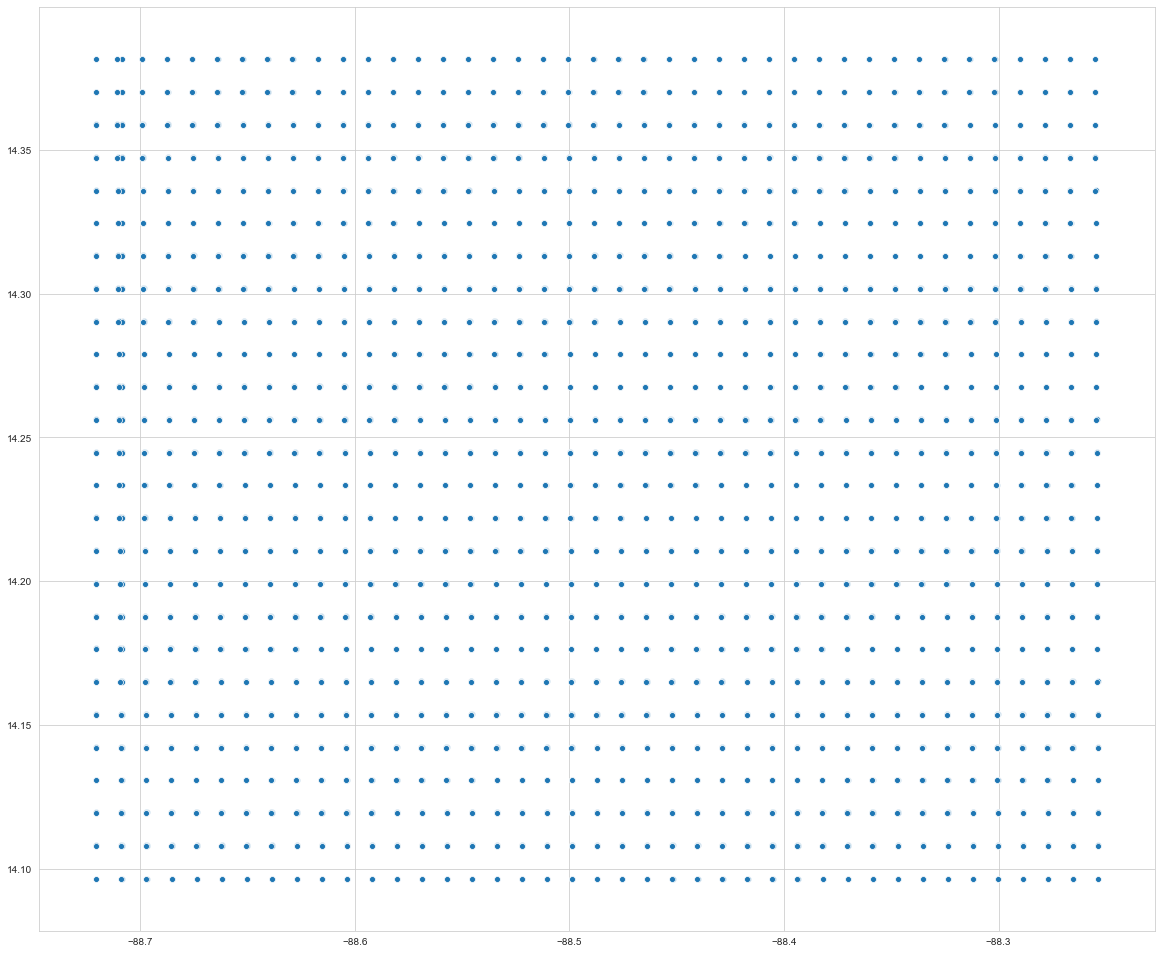

In [15]:
# this needs the first coordinate to not be [coords] for different y steps
def calculate_offset_coords(coords, x_step, y_step, number):
    offset_coords = []
    y_coord = bounding_box(coords, x_step, y_step, expansion = 0)
    y_coord = y_coord[0][1]
    for i in range(number):
        bbx = bounding_box(coords, (i+1)*x_step, y_step, expansion = 0)
        coord_x = bbx[0][0]
        coord_y = y_coord
        offset_coords.append((coord_x, coord_y))
    coords = [(coords[0], y_coord)]
    return coords + offset_coords

SIZE = 9
corner_coordinates = []
for row in range(0, 25):
    temp = calculate_offset_coords(coords, x_step = (SIZE*140), 
                                            y_step = row*(SIZE*140), 
                                            number = 40)
    corner_coordinates.append([[x, [y, row]] for x, y in zip(temp, [col for col in range(0, 40)])])

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style("whitegrid")
plt.figure(figsize=(20, 17))

# So instead of corner coordinates, make the BBoxes to begin with and verify with a plot
# color each box differently

tiled_bbx = []
xs = []
ys =[]
for x in corner_coordinates:
    for y in x:
        bbx = bounding_box(y[0], SIZE*140, SIZE*140, 10)
        xs.append(bbx[0][0])
        xs.append(bbx[1][0])
        
        xs.append(bbx[0][0])
        xs.append(bbx[1][0])
        
        ys.append(bbx[0][1])
        ys.append(bbx[1][1])   
        ys.append(bbx[1][1])
        ys.append(bbx[0][1])
        
sns.scatterplot(x = xs, y = ys)

In [16]:
MDL_PATH = "../src/dsen2/models/"

input_shape = ((4, None, None), (6, None, None))
model = s2model(input_shape, num_layers=6, feature_size=128)
predict_file = MDL_PATH+'s2_032_lr_1e-04.hdf5'
print('Symbolic Model Created.')

model.load_weights(predict_file)

def DSen2(d10, d20):
    test = [d10, d20]
    input_shape = ((4, None, None), (6, None, None))
    prediction = _predict(test, input_shape, deep=False)
    #prediction *= 5
    return prediction

def _predict(test, input_shape, model = model, deep=False, run_60=False):
    
    print("Predicting using file: {}".format(predict_file))
    prediction = model.predict(test, verbose=1)
    return prediction

Symbolic Model Created.


In [17]:
days_per_month = [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30]
starting_days = np.cumsum(days_per_month)

In [18]:
def check_outliers(sample):
    for date in range(24):
        for band in range(10):
            maxs = np.max(sample[date, :, :, band])
            mins = np.min(sample[date, :, :, band])
            if maxs == 1.0 or mins == 0.0:
                print("Found null outlier")
                return True
            if maxs == mins:
                print("Found missing outlier")
                return True
            if maxs >= 1.05 or mins <= -1.05:
                print("Found range outlier")
                return True
    else:
        return False
    
    
def tile_images(arr, output_folder):
    # Normal
    for x_offset, cval in enumerate([x for x in range(0, 126, 14)]):
        for y_offset, rval in enumerate([x for x in range(0, 126, 14)]):
            base_id = 0
            subs = arr[:, cval:cval+16, rval:rval+16]
            np.save(output_folder + str(base_id+x_offset*9+y_offset+1), subs)
            
    # Upright        
    for x_offset, cval in enumerate([x for x in range(7, 126, 14)]):
        for y_offset, rval in enumerate([x for x in range(7, 126, 14)]):
            base_id = 9*9
            subs = arr[:, cval:cval+16, rval:rval+16]
            np.save(output_folder + str(base_id+x_offset*8+y_offset+1), subs)
            
    # Right
    for x_offset, cval in enumerate([x for x in range(7, 119, 14)]):
        for y_offset, rval in enumerate([x for x in range(0, 126, 14)]):
            base_id = (9*9)+(8*8)
            subs = arr[:, cval:cval+16, rval:rval+16]
            np.save(output_folder + str(base_id+x_offset*9+y_offset+1), subs)
            
    # Up
    for x_offset, cval in enumerate([x for x in range(0, 119, 14)]):
        for y_offset, rval in enumerate([x for x in range(7, 126, 14)]):
            base_id = (9*9)+(8*8)+(9*8)
            subs = arr[:, cval:cval+16, rval:rval+16]
            np.save(output_folder + str(base_id+x_offset*8+y_offset+1), subs)
            
            
def calculate_proximal_steps(date, satisfactory):
    arg_before = None
    arg_after = None
    if date > 0:
        idx_before = satisfactory - date
        arg_before = idx_before[np.where(idx_before < 0, idx_before, -np.inf).argmax()]
    if date < np.max(satisfactory):
        idx_after = satisfactory - date
        arg_after = idx_after[np.where(idx_after > 0, idx_after, np.inf).argmin()]
    if not arg_after and not arg_before:
        arg_after = date
        arg_before = date
    if not arg_after:
        arg_after = arg_before
    if not arg_before:
        arg_before = arg_after
    #print(arg_before, date, arg_after)
    return arg_before, arg_after

def worker_download(coord, folder = OUTPUT_FOLDER, year = 2019):
    idx_x = coord[1][0]
    idx_y = coord[1][1]
    start = timer()
    print("Starting: {} {}".format(idx_x, idx_y))
    coord = coord[0]
    output_folder = OUTPUT_FOLDER + "{}".format(str(idx_y))
    if not os.path.exists(os.path.realpath(output_folder)):
        os.makedirs(os.path.realpath(output_folder))
    existing = [x for x in os.listdir(os.path.realpath(output_folder))]
    if str(idx_x) + ".npy" not in existing:
        tiled_bbx = bounding_box(coord, y_offset_max = (SIZE*140)-0, x_offset_max = (SIZE*140)+0, expansion = 10)
        dem_bbx = bounding_box(coord, y_offset_max = SIZE*140, x_offset_max = SIZE*140, expansion = 20)
        cloud_timer = timer()
        clean_steps, means, cloud_probs = identify_clouds(tiled_bbx)
        
        ## SENTINEL 1 BLOCK HERE
        s1, s1_dates = download_sentinel_1(tiled_bbx, layer = 'SENT')
        print("ASCENDING: {}".format(s1.shape))
        if s1.shape[0] == 0:
            s1, s1_dates = download_sentinel_1(tiled_bbx, layer = "SENT_DESC")
            print("DESCENDING: {}".format(s1.shape))
        if s1_dates.shape[0] > 0:
            s1 = calculate_and_save_best_images(s1, s1_dates)


            # Retain only iamgery every 15 days
            biweekly_dates = np.array([day for day in range(0, 360, 5)])
            to_remove = np.argwhere(biweekly_dates % 15 != 0)
            s1 = np.delete(s1, to_remove, 0)
        
        tiles, request, shadows, shadow_steps = download_layer(tiled_bbx)
        print("Downloaded imagery")
        cloud_end = timer()
        print("The imagery calcs and data take {}".format(cloud_end - cloud_timer))
        
        image_dates = []
        for date in request.get_dates():
            if date.year == year - 1:
                image_dates.append(-365 + starting_days[(date.month-1)] + date.day)
            if date.year == year:
                image_dates.append(starting_days[(date.month-1)] + date.day)
            if date.year == year + 1:
                image_dates.append(365 + starting_days[(date.month-1)]+date.day)
        image_dates = np.array(image_dates)

        args = np.array([len(np.argwhere(cloud_probs[x, :, :].reshape((128)*(128)) > 0.3)) for x in range(cloud_probs.shape[0])])
        dirty_steps = np.argwhere(args > (128)*(128) / 4)
        missing_images = [np.argwhere(tiles[x, :, : :10].flatten() == 0.0) for x in range(tiles.shape[0])]
        missing_images = np.array([len(x) for x in missing_images])
        missing_images_p = [np.argwhere(tiles[x, :, : :10].flatten() >= 1) for x in range(tiles.shape[0])]
        missing_images_p = np.array([len(x) for x in missing_images_p])
        missing_images += missing_images_p
        missing_images = list(np.argwhere(missing_images >= 100))
        to_remove = np.unique(np.array(list(dirty_steps) + list(missing_images) + list(shadow_steps)))

        # Remove null steps
        print("There are {}/{} dirty steps: {} cloud, {} missing, {} shadows".format(len(to_remove),
                                                                                    len(tiles), len(dirty_steps),
                                                                                    len(missing_images),
                                                                                    len(shadow_steps)))

        tiles = np.delete(tiles, to_remove, 0)
        cloud_probs = np.delete(cloud_probs, to_remove, 0)
        image_dates = np.delete(image_dates, to_remove)
        shadows = np.delete(shadows, to_remove, 0)
        #tiles = remove_blank_steps(tiles)
        
        to_remove = remove_missed_clouds(tiles)
        tiles = np.delete(tiles, to_remove, 0)
        cloud_probs = np.delete(cloud_probs, to_remove, 0)
        shadows = np.delete(shadows, to_remove, 0)
        image_dates = np.delete(image_dates, to_remove)
        print("Removing {} steps based on ratio".format(len(to_remove)))
        
        bef = timer()
        dem = download_dem(dem_bbx)
        dem = np.tile(dem[np.newaxis, :, :, :], (tiles.shape[0], 1, 1, 1))
        tiles = np.concatenate([tiles, dem], axis = -1)
        tiles[:, :, :, 10] /= 90
        aft = timer()
        print("The DEM calcs took {}".format(aft - bef))
        
        new_shadows = threshold_shadows(tiles[:, :, :, 3])
        x, new_probs, mid_probs = remove_cloud_and_shadows(tiles, cloud_probs, new_shadows, image_dates)
        bef = timer()
        print("Before super: {}".format(x.shape))

        d10 = x[:, :, :, 0:4]
        d20 = x[:, :, :, 4:10]

        d10 = np.swapaxes(d10, 1, -1)
        d10 = np.swapaxes(d10, 2, 3)
        d20 = np.swapaxes(d20, 1, -1)
        d20 = np.swapaxes(d20, 2, 3)
        superresolved = DSen2(d10, d20)
        superresolved = np.swapaxes(superresolved, 1, -1)
        superresolved = np.swapaxes(superresolved, 1, 2)

        # returns band IDXs 3, 4, 5, 7, 8, 9
        x[:, :, :, 4:10] = superresolved
        aft = timer()
        print("The superresolve took: {}".format(aft - bef))
        x, amin = evi(x, True)
        x = bi(x, True)
        x = msavi2(x, True)
        x = si(x, True)
        
        # check for and remove null values
        
        missing_pixels = 0
        for band in range(0, 15):
            for time in range(0, x.shape[0]):
                x_i = x[time, :, :, band]
                missing_pixels += len(np.argwhere(np.isnan(x_i)))
                x_i[np.argwhere(np.isnan(x_i))] = np.mean(x_i)
                x[time, :, :, band] = x_i
        print("There are {} missing pixels".format(missing_pixels))
        
        
        x = calculate_and_save_best_images(x, image_dates)
        
        bef = timer()
        no_dem = np.delete(x, 10, -1)
        no_dem = np.reshape(no_dem, (72, 128*128*14))
        no_dem = np.swapaxes(no_dem, 0, 1)
        
        pool = multiprocessing.Pool(6)
        no_dem = pool.map(smooth, no_dem)
        pool.close()
        pool.join()
        
        no_dem = np.swapaxes(no_dem, 0, 1)
        no_dem = np.reshape(no_dem, (72, 128, 128, 14))
        x[:, :, :, :10] = no_dem[:, :, :, :10]
        x[:, :, :, 11:] = no_dem[:, :, :, 10:]
        aft = timer()
        print("The interpolation of pixels took {}".format(aft - bef))
        
        #for row in range(0, (SIZE*14)+2):
        #    for column in range(0, (SIZE*14)+2):
        #        for band in [x for x in range(0, 15) if x != 10]:
        #            x[:, row, column, band] = smooth(x[:, row, column, band], 800, d = 2)
        
        biweekly_dates = np.array([day for day in range(0, 360, 5)])
        to_remove = np.argwhere(biweekly_dates % 15 != 0)
        x = np.delete(x, to_remove, 0)
        print(x.shape)
        print(s1.shape)
        
        fused = np.concatenate([x, s1], axis = -1)
        print(fused.shape)
        np.save(output_folder + "/" + str(idx_x) + ".npy", fused)
        end = timer()
        print("Finished in {}".format(end - start))
        return fused, cloud_probs

In [19]:
for r in range(0, 25):
    for c in range(0, 35):
        x2 = worker_download(corner_coordinates[r][c])

Starting: 0 0
Starting: 1 0
Starting: 2 0
ASCENDING: (14, 128, 128, 2)
Maximum time distance: 35
Original size: (65, 130, 127, 6)
Original 10 size: (65, 130, 127, 5)
Data shape: (65, 128, 128)
Downloaded imagery
The imagery calcs and data take 25.427406072616577
There are 7/65 dirty steps: 7 cloud, 1 missing, 0 shadows
Removing 0 steps based on ratio
The DEM calcs took 3.2132151126861572
Removed 69632.0 fake shadows, leaving 154112.0
The total percent shadow cover is: 0.16217672413793102%
A total of 10704 pixels were interpolated
Before super: (58, 128, 128, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
58/58 [==============================] - 33s 565ms/step
The superresolve took: 32.797680139541626
There are: 0 out of bounds EVI
()
evis error: -0.022680191323161125, 1.2569676637649536, 0 steps, clipping to -1.5, 1.5
There are 0 missing pixels
Maximum time distance: 25
The interpolation of pixels took 60.30597686767578
(24, 128, 128, 15)
(24, 128, 128, 2)
(24, 128

The DEM calcs took 1.9006807804107666
Removed 56640.0 fake shadows, leaving 183936.0
The total percent shadow cover is: 0.23388671875%
A total of 13033 pixels were interpolated
Before super: (48, 128, 128, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
48/48 [==============================] - 29s 610ms/step
The superresolve took: 29.286458253860474
There are: 0 out of bounds EVI
()
evis error: 0.022392455488443375, 1.082898497581482, 0 steps, clipping to -1.5, 1.5
There are 0 missing pixels
Maximum time distance: 40
The interpolation of pixels took 65.48791790008545
(24, 128, 128, 15)
(24, 128, 128, 2)
(24, 128, 128, 17)
Finished in 135.80905604362488
Starting: 11 0
ASCENDING: (14, 128, 128, 2)
Maximum time distance: 35
Original size: (65, 130, 127, 6)
Original 10 size: (65, 130, 127, 5)
Data shape: (65, 128, 128)
Downloaded imagery
The imagery calcs and data take 25.283721923828125
There are 21/65 dirty steps: 19 cloud, 4 missing, 1 shadows
Removing 0 steps based 

41/41 [==============================] - 25s 609ms/step
The superresolve took: 24.98503017425537
There are: 1 out of bounds EVI
()
evis error: 0.024635400623083115, 11.6875638961792, 1 steps, clipping to -1.5, 1.5
There are 0 missing pixels
Maximum time distance: 55
The interpolation of pixels took 67.53371810913086
(24, 128, 128, 15)
(24, 128, 128, 2)
(24, 128, 128, 17)
Finished in 131.97103214263916
Starting: 19 0
ASCENDING: (14, 128, 128, 2)
Maximum time distance: 35
Original size: (65, 130, 127, 6)
Original 10 size: (65, 130, 127, 5)
Data shape: (65, 128, 128)
Downloaded imagery
The imagery calcs and data take 28.946456909179688
There are 30/65 dirty steps: 29 cloud, 15 missing, 1 shadows
Removing 0 steps based on ratio
The DEM calcs took 2.0004470348358154
Removed 105920.0 fake shadows, leaving 460672.0
The total percent shadow cover is: 0.8033482142857142%
A total of 14498 pixels were interpolated
Before super: (35, 128, 128, 11)
Predicting using file: ../src/dsen2/models/s2_032_

/Users/john.brandt/Documents/GitHub/restoration-mapper/src/utils-bilinear.py:102: RuntimeWarning: invalid value encountered in power
  sis = np.power( (1-BLUE) * (1 - GREEN) * (1 - RED), 1/3)


There are 3 missing pixels
Maximum time distance: 40
The interpolation of pixels took 67.14813804626465
(24, 128, 128, 15)
(24, 128, 128, 2)
(24, 128, 128, 17)
Finished in 145.94054102897644
Starting: 26 0
ASCENDING: (14, 128, 128, 2)
Maximum time distance: 35
Original size: (65, 129, 127, 6)
Original 10 size: (65, 129, 127, 5)
Data shape: (65, 128, 128)
Downloaded imagery
The imagery calcs and data take 26.938347101211548
There are 13/65 dirty steps: 11 cloud, 0 missing, 2 shadows
Removing 0 steps based on ratio
The DEM calcs took 1.6885559558868408
Removed 40768.0 fake shadows, leaving 0.0
The total percent shadow cover is: 0.0%
A total of 8141 pixels were interpolated
Before super: (52, 128, 128, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
52/52 [==============================] - 32s 620ms/step
The superresolve took: 32.22928714752197
There are: 0 out of bounds EVI
()
evis error: -0.1704891324043274, 1.1062965393066406, 0 steps, clipping to -1.5, 1.5
There ar

ASCENDING: (14, 128, 128, 2)
Maximum time distance: 35
Original size: (65, 129, 127, 6)
Original 10 size: (65, 129, 127, 5)
Data shape: (65, 128, 128)
Downloaded imagery
The imagery calcs and data take 26.318907260894775
There are 11/65 dirty steps: 11 cloud, 4 missing, 0 shadows
Removing 0 steps based on ratio
The DEM calcs took 1.8026816844940186
Removed 262016.0 fake shadows, leaving 76864.0
The total percent shadow cover is: 0.08687789351851852%
A total of 6496 pixels were interpolated
Before super: (54, 128, 128, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
54/54 [==============================] - 33s 617ms/step
The superresolve took: 33.35291862487793
There are: 0 out of bounds EVI
()
evis error: -0.2302975356578827, 1.5152853727340698, 0 steps, clipping to -1.5, 1.5
There are 0 missing pixels
Maximum time distance: 25
The interpolation of pixels took 66.3438241481781
(24, 128, 128, 15)
(24, 128, 128, 2)
(24, 128, 128, 17)
Finished in 142.9395158290863
Star

Data shape: (65, 128, 128)
Downloaded imagery
The imagery calcs and data take 26.961636781692505
There are 10/65 dirty steps: 8 cloud, 2 missing, 3 shadows
Removing 0 steps based on ratio
The DEM calcs took 2.6564390659332275
Removed 37248.0 fake shadows, leaving 15488.0
The total percent shadow cover is: 0.0171875%
A total of 3985 pixels were interpolated
Before super: (55, 128, 128, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
55/55 [==============================] - 33s 601ms/step
The superresolve took: 33.05126404762268
There are: 0 out of bounds EVI
()
evis error: 0.10122077167034149, 1.337032437324524, 0 steps, clipping to -1.5, 1.5
There are 0 missing pixels
Maximum time distance: 25
The interpolation of pixels took 69.87841486930847
(24, 128, 128, 15)
(24, 128, 128, 2)
(24, 128, 128, 17)
Finished in 147.59232091903687
Starting: 8 1
ASCENDING: (14, 128, 128, 2)
Maximum time distance: 35
Original size: (65, 130, 127, 6)
Original 10 size: (65, 130, 127, 5)
D

/Users/john.brandt/Documents/GitHub/restoration-mapper/src/utils-bilinear.py:102: RuntimeWarning: invalid value encountered in power
  sis = np.power( (1-BLUE) * (1 - GREEN) * (1 - RED), 1/3)


There are 3 missing pixels
Maximum time distance: 55
The interpolation of pixels took 66.24027919769287
(24, 128, 128, 15)
(24, 128, 128, 2)
(24, 128, 128, 17)
Finished in 132.7936851978302
Starting: 14 1
ASCENDING: (14, 128, 128, 2)
Maximum time distance: 35
Original size: (65, 130, 127, 6)
Original 10 size: (65, 130, 127, 5)
Data shape: (65, 128, 128)
Downloaded imagery
The imagery calcs and data take 26.211631774902344
There are 30/65 dirty steps: 29 cloud, 9 missing, 2 shadows
Removing 0 steps based on ratio
The DEM calcs took 1.6999311447143555
Removed 86336.0 fake shadows, leaving 89984.0
The total percent shadow cover is: 0.15691964285714285%
A total of 12222 pixels were interpolated
Before super: (35, 128, 128, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
35/35 [==============================] - 21s 590ms/step
The superresolve took: 20.657229900360107
There are: 0 out of bounds EVI
()
evis error: 0.04908590763807297, 1.161252737045288, 0 steps, clipping t

ASCENDING: (14, 128, 128, 2)
Maximum time distance: 35
Original size: (65, 129, 127, 6)
Original 10 size: (65, 129, 127, 5)
Data shape: (65, 128, 128)
Downloaded imagery
The imagery calcs and data take 27.08313012123108
There are 13/65 dirty steps: 12 cloud, 6 missing, 1 shadows
Removing 0 steps based on ratio
The DEM calcs took 1.6847660541534424
Removed 27712.0 fake shadows, leaving 142656.0
The total percent shadow cover is: 0.16744290865384615%
A total of 3786 pixels were interpolated
Before super: (52, 128, 128, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
52/52 [==============================] - 32s 621ms/step
The superresolve took: 32.2925808429718
There are: 0 out of bounds EVI
There are 0 missing pixels
Maximum time distance: 40
The interpolation of pixels took 67.78715801239014
(24, 128, 128, 15)
(24, 128, 128, 2)
(24, 128, 128, 17)
Finished in 142.88225293159485
Starting: 23 1
ASCENDING: (14, 128, 128, 2)
Maximum time distance: 35
Original size: (65, 1

/Users/john.brandt/Documents/GitHub/restoration-mapper/src/utils-bilinear.py:102: RuntimeWarning: invalid value encountered in power
  sis = np.power( (1-BLUE) * (1 - GREEN) * (1 - RED), 1/3)


There are 2 missing pixels
Maximum time distance: 25
The interpolation of pixels took 70.5647120475769
(24, 128, 128, 15)
(24, 128, 128, 2)
(24, 128, 128, 17)
Finished in 147.3078100681305
Starting: 30 1
ASCENDING: (14, 128, 128, 2)
Maximum time distance: 35
Original size: (65, 129, 127, 6)
Original 10 size: (65, 129, 127, 5)
Data shape: (65, 128, 128)
Downloaded imagery
The imagery calcs and data take 27.687453985214233
There are 12/65 dirty steps: 10 cloud, 3 missing, 2 shadows
Removing 0 steps based on ratio
The DEM calcs took 1.9329309463500977
Removed 34880.0 fake shadows, leaving 263552.0
The total percent shadow cover is: 0.3035082547169811%
A total of 12346 pixels were interpolated
Before super: (53, 128, 128, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
53/53 [==============================] - 32s 604ms/step
The superresolve took: 32.02292990684509
There are: 0 out of bounds EVI
()
evis error: -0.16011926531791687, 1.554520606994629, 0 steps, clipping to

ASCENDING: (14, 128, 128, 2)
Maximum time distance: 35
Original size: (65, 130, 127, 6)
Original 10 size: (65, 130, 127, 5)
Data shape: (65, 128, 128)
Downloaded imagery
The imagery calcs and data take 27.365519046783447
There are 10/65 dirty steps: 10 cloud, 1 missing, 0 shadows
Removing 0 steps based on ratio
The DEM calcs took 1.859212875366211
Removed 26432.0 fake shadows, leaving 142848.0
The total percent shadow cover is: 0.15852272727272726%
A total of 8558 pixels were interpolated
Before super: (55, 128, 128, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
55/55 [==============================] - 35s 628ms/step
The superresolve took: 34.53250527381897
There are: 0 out of bounds EVI
There are 0 missing pixels
Maximum time distance: 25
The interpolation of pixels took 66.62832498550415
(24, 128, 128, 15)
(24, 128, 128, 2)
(24, 128, 128, 17)
Finished in 145.39148211479187
Starting: 4 2
ASCENDING: (14, 128, 128, 2)
Maximum time distance: 35
Original size: (65, 1

The DEM calcs took 2.0942459106445312
Removed 82046.0 fake shadows, leaving 241216.0
The total percent shadow cover is: 0.36806640625%
A total of 19692 pixels were interpolated
Before super: (40, 128, 128, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
40/40 [==============================] - 25s 623ms/step
The superresolve took: 24.928160905838013
There are: 1 out of bounds EVI
()
evis error: -0.28328612446784973, 4.489485740661621, 1 steps, clipping to -1.5, 1.5


/Users/john.brandt/Documents/GitHub/restoration-mapper/src/utils-bilinear.py:102: RuntimeWarning: invalid value encountered in power
  sis = np.power( (1-BLUE) * (1 - GREEN) * (1 - RED), 1/3)


There are 1 missing pixels
Maximum time distance: 55
The interpolation of pixels took 67.92727494239807
(24, 128, 128, 15)
(24, 128, 128, 2)
(24, 128, 128, 17)
Finished in 134.6701283454895
Starting: 12 2
ASCENDING: (14, 128, 128, 2)
Maximum time distance: 35
Original size: (65, 130, 127, 6)
Original 10 size: (65, 130, 127, 5)
Data shape: (65, 128, 128)
Downloaded imagery
The imagery calcs and data take 31.22226309776306
There are 30/65 dirty steps: 30 cloud, 12 missing, 0 shadows
Removing 0 steps based on ratio
The DEM calcs took 1.8987772464752197
Removed 150272.0 fake shadows, leaving 86784.0
The total percent shadow cover is: 0.1513392857142857%
A total of 15100 pixels were interpolated
Before super: (35, 128, 128, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
35/35 [==============================] - 22s 614ms/step
The superresolve took: 21.510643005371094
There are: 0 out of bounds EVI
()
evis error: 0.039507899433374405, 1.103737473487854, 0 steps, clipping 

/Users/john.brandt/Documents/GitHub/restoration-mapper/src/utils-bilinear.py:102: RuntimeWarning: invalid value encountered in power
  sis = np.power( (1-BLUE) * (1 - GREEN) * (1 - RED), 1/3)


There are 1 missing pixels
Maximum time distance: 105
The interpolation of pixels took 67.75309705734253
(24, 128, 128, 15)
(24, 128, 128, 2)
(24, 128, 128, 17)
Finished in 129.42210006713867
Starting: 16 2
ASCENDING: (14, 128, 128, 2)
Maximum time distance: 35
Original size: (65, 130, 127, 6)
Original 10 size: (65, 130, 127, 5)
Data shape: (65, 128, 128)
Downloaded imagery
The imagery calcs and data take 26.79538893699646
There are 28/65 dirty steps: 27 cloud, 12 missing, 1 shadows
Removing 0 steps based on ratio
The DEM calcs took 2.932337999343872
Removed 81792.0 fake shadows, leaving 552064.0
The total percent shadow cover is: 0.9106841216216216%
A total of 18660 pixels were interpolated
Before super: (37, 128, 128, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
37/37 [==============================] - 23s 618ms/step
The superresolve took: 22.86365795135498
There are: 2 out of bounds EVI
()
evis error: -4.177731990814209, 2.083158016204834, 1 steps, clipping to

/Users/john.brandt/Documents/GitHub/restoration-mapper/src/utils-bilinear.py:102: RuntimeWarning: invalid value encountered in power
  sis = np.power( (1-BLUE) * (1 - GREEN) * (1 - RED), 1/3)


There are 1 missing pixels
Maximum time distance: 50
The interpolation of pixels took 70.03943920135498
(24, 128, 128, 15)
(24, 128, 128, 2)
(24, 128, 128, 17)
Finished in 145.41443037986755
Starting: 22 2
ASCENDING: (14, 128, 128, 2)
Maximum time distance: 35
Original size: (65, 129, 127, 6)
Original 10 size: (65, 129, 127, 5)
Data shape: (65, 128, 128)
Downloaded imagery
The imagery calcs and data take 27.503593921661377
There are 16/65 dirty steps: 12 cloud, 4 missing, 5 shadows
Removing 0 steps based on ratio
The DEM calcs took 1.8841779232025146
Removed 96832.0 fake shadows, leaving 34240.0
The total percent shadow cover is: 0.042649872448979595%
A total of 4660 pixels were interpolated
Before super: (49, 128, 128, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
49/49 [==============================] - 30s 621ms/step
The superresolve took: 30.420111179351807
There are: 3 out of bounds EVI
()
evis error: -7.745956897735596, 4.145163059234619, 3 steps, clipping t

Original 10 size: (65, 129, 127, 5)
Data shape: (65, 128, 128)
Downloaded imagery
The imagery calcs and data take 28.020041942596436
There are 15/65 dirty steps: 12 cloud, 3 missing, 3 shadows
Removing 0 steps based on ratio
The DEM calcs took 2.1007039546966553
Removed 47552.0 fake shadows, leaving 66304.0
The total percent shadow cover is: 0.0809375%
A total of 6645 pixels were interpolated
Before super: (50, 128, 128, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
50/50 [==============================] - 30s 597ms/step
The superresolve took: 29.861109972000122
There are: 0 out of bounds EVI
()
evis error: 0.019851714372634888, 1.830840826034546, 0 steps, clipping to -1.5, 1.5
There are 0 missing pixels
Maximum time distance: 25
The interpolation of pixels took 66.35057091712952
(24, 128, 128, 15)
(24, 128, 128, 2)
(24, 128, 128, 17)
Finished in 140.06909704208374
Starting: 31 2
ASCENDING: (14, 128, 128, 2)
Maximum time distance: 35
Original size: (65, 129, 127, 

The DEM calcs took 1.8832440376281738
Removed 32576.0 fake shadows, leaving 113280.0
The total percent shadow cover is: 0.12346540178571429%
A total of 12741 pixels were interpolated
Before super: (56, 128, 128, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
56/56 [==============================] - 35s 630ms/step
The superresolve took: 35.29501414299011
There are: 0 out of bounds EVI
()
evis error: 0.03708312660455704, 1.0087392330169678, 0 steps, clipping to -1.5, 1.5
There are 0 missing pixels
Maximum time distance: 40
The interpolation of pixels took 69.79801797866821
(24, 128, 128, 15)
(24, 128, 128, 2)
(24, 128, 128, 17)
Finished in 149.8884198665619
Starting: 4 3
ASCENDING: (14, 128, 128, 2)
Maximum time distance: 35
Original size: (65, 130, 127, 6)
Original 10 size: (65, 130, 127, 5)
Data shape: (65, 128, 128)
Downloaded imagery
The imagery calcs and data take 33.2158739566803
There are 7/65 dirty steps: 7 cloud, 0 missing, 0 shadows
Removing 0 steps based o

36/36 [==============================] - 21s 592ms/step
The superresolve took: 21.323870182037354
There are: 0 out of bounds EVI
()
evis error: -0.011501629836857319, 1.9377987384796143, 0 steps, clipping to -1.5, 1.5
There are 0 missing pixels
Maximum time distance: 55
The interpolation of pixels took 70.43996906280518
(24, 128, 128, 15)
(24, 128, 128, 2)
(24, 128, 128, 17)
Finished in 130.56624627113342
Starting: 12 3
ASCENDING: (14, 128, 128, 2)
Maximum time distance: 35
Original size: (65, 130, 127, 6)
Original 10 size: (65, 130, 127, 5)
Data shape: (65, 128, 128)
Downloaded imagery
The imagery calcs and data take 31.017189741134644
There are 32/65 dirty steps: 30 cloud, 15 missing, 1 shadows
Removing 0 steps based on ratio
The DEM calcs took 1.6779892444610596
Removed 68224.0 fake shadows, leaving 417088.0
The total percent shadow cover is: 0.7714251893939394%
A total of 19428 pixels were interpolated
Before super: (33, 128, 128, 11)
Predicting using file: ../src/dsen2/models/s2_0

/Users/john.brandt/Documents/GitHub/restoration-mapper/src/utils-bilinear.py:102: RuntimeWarning: invalid value encountered in power
  sis = np.power( (1-BLUE) * (1 - GREEN) * (1 - RED), 1/3)


There are 4 missing pixels
Maximum time distance: 70
The interpolation of pixels took 69.18226909637451
(24, 128, 128, 15)
(24, 128, 128, 2)
(24, 128, 128, 17)
Finished in 131.40469408035278
Starting: 17 3
ASCENDING: (14, 128, 128, 2)
Maximum time distance: 35
Original size: (65, 130, 127, 6)
Original 10 size: (65, 130, 127, 5)
Data shape: (65, 128, 128)
Downloaded imagery
The imagery calcs and data take 27.367308855056763
There are 22/65 dirty steps: 22 cloud, 6 missing, 0 shadows
Removing 0 steps based on ratio
The DEM calcs took 1.7204627990722656
Removed 67904.0 fake shadows, leaving 303104.0
The total percent shadow cover is: 0.43023255813953487%
A total of 24548 pixels were interpolated
Before super: (43, 128, 128, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
43/43 [==============================] - 27s 619ms/step
The superresolve took: 26.648859977722168
There are: 1 out of bounds EVI
()
evis error: -5.330381393432617, 2.4858243465423584, 1 steps, clipping

/Users/john.brandt/Documents/GitHub/restoration-mapper/src/utils-bilinear.py:102: RuntimeWarning: invalid value encountered in power
  sis = np.power( (1-BLUE) * (1 - GREEN) * (1 - RED), 1/3)


There are 1 missing pixels
Maximum time distance: 50
The interpolation of pixels took 65.32307195663452
(24, 128, 128, 15)
(24, 128, 128, 2)
(24, 128, 128, 17)
Finished in 135.77531504631042
Starting: 19 3
ASCENDING: (14, 128, 128, 2)
Maximum time distance: 35
Original size: (65, 130, 127, 6)
Original 10 size: (65, 130, 127, 5)
Data shape: (65, 128, 128)
Downloaded imagery
The imagery calcs and data take 29.601303100585938
There are 20/65 dirty steps: 17 cloud, 11 missing, 1 shadows
Removing 0 steps based on ratio
The DEM calcs took 1.9692583084106445
Removed 130525.75 fake shadows, leaving 183104.0
The total percent shadow cover is: 0.24835069444444444%
A total of 7034 pixels were interpolated
Before super: (45, 128, 128, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
45/45 [==============================] - 27s 598ms/step
The superresolve took: 26.939443826675415
There are: 0 out of bounds EVI
()
evis error: -0.00796768069267273, 1.757356882095337, 0 steps, clipp

Original 10 size: (65, 129, 127, 5)
Data shape: (65, 128, 128)
Downloaded imagery
The imagery calcs and data take 25.91071105003357
There are 17/65 dirty steps: 15 cloud, 6 missing, 2 shadows
Removing 0 steps based on ratio
The DEM calcs took 1.7404758930206299
Removed 65024.0 fake shadows, leaving 323264.0
The total percent shadow cover is: 0.4110514322916667%
A total of 10292 pixels were interpolated
Before super: (48, 128, 128, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
48/48 [==============================] - 28s 592ms/step
The superresolve took: 28.423784017562866
There are: 3 out of bounds EVI
()
evis error: -6.868563175201416, 3.007599115371704, 3 steps, clipping to -1.5, 1.5
There are 0 missing pixels
Maximum time distance: 50
The interpolation of pixels took 67.46372413635254
(24, 128, 128, 15)
(24, 128, 128, 2)
(24, 128, 128, 17)
Finished in 136.66536712646484
Starting: 28 3
ASCENDING: (14, 128, 128, 2)
Maximum time distance: 35
Original size: (65, 12

/Users/john.brandt/Documents/GitHub/restoration-mapper/src/utils-bilinear.py:102: RuntimeWarning: invalid value encountered in power
  sis = np.power( (1-BLUE) * (1 - GREEN) * (1 - RED), 1/3)


There are 1 missing pixels
Maximum time distance: 25
The interpolation of pixels took 71.44267296791077
(24, 128, 128, 15)
(24, 128, 128, 2)
(24, 128, 128, 17)
Finished in 145.3137731552124
Starting: 31 3
ASCENDING: (14, 128, 128, 2)
Maximum time distance: 35
Original size: (65, 129, 127, 6)
Original 10 size: (65, 129, 127, 5)
Data shape: (65, 128, 128)
Downloaded imagery
The imagery calcs and data take 26.91796088218689
There are 14/65 dirty steps: 13 cloud, 3 missing, 1 shadows
Removing 0 steps based on ratio
The DEM calcs took 1.7318809032440186
Removed 34240.0 fake shadows, leaving 219072.0
The total percent shadow cover is: 0.26217830882352944%
A total of 6265 pixels were interpolated
Before super: (51, 128, 128, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
51/51 [==============================] - 31s 599ms/step
The superresolve took: 30.55248188972473
There are: 2 out of bounds EVI
()
evis error: -11.628355979919434, 5.4310197830200195, 2 steps, clipping to

ASCENDING: (14, 128, 128, 2)
Maximum time distance: 35
Original size: (65, 130, 127, 6)
Original 10 size: (65, 130, 127, 5)
Data shape: (65, 128, 128)
Downloaded imagery
The imagery calcs and data take 27.61202096939087
There are 8/65 dirty steps: 8 cloud, 0 missing, 0 shadows
Removing 0 steps based on ratio
The DEM calcs took 1.7550170421600342
Removed 557696.0 fake shadows, leaving 45440.0
The total percent shadow cover is: 0.04865679824561404%
A total of 9528 pixels were interpolated
Before super: (57, 128, 128, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
57/57 [==============================] - 34s 599ms/step
The superresolve took: 34.13992476463318
There are: 0 out of bounds EVI
()
evis error: -0.1973448395729065, 1.3935543298721313, 0 steps, clipping to -1.5, 1.5
There are 0 missing pixels
Maximum time distance: 25
The interpolation of pixels took 65.44252109527588
(24, 128, 128, 15)
(24, 128, 128, 2)
(24, 128, 128, 17)
Finished in 145.29971599578857
Start

Data shape: (65, 128, 128)
Downloaded imagery
The imagery calcs and data take 26.189733028411865
There are 34/65 dirty steps: 33 cloud, 20 missing, 0 shadows
Removing 0 steps based on ratio
The DEM calcs took 2.2603559494018555
Removed 50074.515625 fake shadows, leaving 103251.171875
The total percent shadow cover is: 0.20328875510923325%
A total of 9823 pixels were interpolated
Before super: (31, 128, 128, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
31/31 [==============================] - 19s 624ms/step
The superresolve took: 19.36275005340576
There are: 1 out of bounds EVI
()
evis error: 0.046883754432201385, 3.4537911415100098, 1 steps, clipping to -1.5, 1.5
There are 0 missing pixels
Maximum time distance: 60
The interpolation of pixels took 74.1971960067749
(24, 128, 128, 15)
(24, 128, 128, 2)
(24, 128, 128, 17)
Finished in 131.4421398639679
Starting: 13 4
ASCENDING: (14, 128, 128, 2)
Maximum time distance: 35
Original size: (65, 130, 127, 6)
Original 10 s

/Users/john.brandt/Documents/GitHub/restoration-mapper/src/utils-bilinear.py:102: RuntimeWarning: invalid value encountered in power
  sis = np.power( (1-BLUE) * (1 - GREEN) * (1 - RED), 1/3)


There are 1 missing pixels
Maximum time distance: 40
The interpolation of pixels took 67.46659588813782
(24, 128, 128, 15)
(24, 128, 128, 2)
(24, 128, 128, 17)
Finished in 138.4749460220337
Starting: 19 4
ASCENDING: (14, 128, 128, 2)
Maximum time distance: 35
Original size: (65, 130, 127, 6)
Original 10 size: (65, 130, 127, 5)
Data shape: (65, 128, 128)
Downloaded imagery
The imagery calcs and data take 28.069658994674683
There are 17/65 dirty steps: 15 cloud, 10 missing, 0 shadows
Removing 0 steps based on ratio
The DEM calcs took 1.9544188976287842
Removed 40807.25 fake shadows, leaving 43776.8203125
The total percent shadow cover is: 0.05566510558128357%
A total of 6536 pixels were interpolated
Before super: (48, 128, 128, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
48/48 [==============================] - 29s 613ms/step
The superresolve took: 29.446415901184082
There are: 9 out of bounds EVI
()
evis error: 0.025031592696905136, 11.700397491455078, 1 steps, c

Original size: (65, 129, 127, 6)
Original 10 size: (65, 129, 127, 5)
Data shape: (65, 128, 128)
Downloaded imagery
The imagery calcs and data take 26.43140983581543
There are 20/65 dirty steps: 20 cloud, 7 missing, 2 shadows
Removing 0 steps based on ratio
The DEM calcs took 1.1449222564697266
Removed 119872.0 fake shadows, leaving 305856.0
The total percent shadow cover is: 0.41484375%
A total of 9321 pixels were interpolated
Before super: (45, 128, 128, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
45/45 [==============================] - 28s 620ms/step
The superresolve took: 27.916977882385254
There are: 2 out of bounds EVI
()
evis error: 0.020266149193048477, 9.965408325195312, 2 steps, clipping to -1.5, 1.5
There are 0 missing pixels
Maximum time distance: 50
The interpolation of pixels took 66.55543518066406
(24, 128, 128, 15)
(24, 128, 128, 2)
(24, 128, 128, 17)
Finished in 134.78654170036316
Starting: 28 4
ASCENDING: (14, 128, 128, 2)
Maximum time distance

/Users/john.brandt/Documents/GitHub/restoration-mapper/src/utils-bilinear.py:102: RuntimeWarning: invalid value encountered in power
  sis = np.power( (1-BLUE) * (1 - GREEN) * (1 - RED), 1/3)


There are 1 missing pixels
Maximum time distance: 25
The interpolation of pixels took 66.28636622428894
(24, 128, 128, 15)
(24, 128, 128, 2)
(24, 128, 128, 17)
Finished in 140.69089794158936
Starting: 0 5
ASCENDING: (14, 128, 128, 2)
Maximum time distance: 35
Original size: (65, 130, 127, 6)
Original 10 size: (65, 130, 127, 5)
Data shape: (65, 128, 128)
Downloaded imagery
The imagery calcs and data take 26.594314575195312
There are 19/65 dirty steps: 18 cloud, 4 missing, 2 shadows
Removing 0 steps based on ratio
The DEM calcs took 1.6824440956115723
Removed 16448.0 fake shadows, leaving 5440.0
The total percent shadow cover is: 0.007218070652173913%
A total of 13849 pixels were interpolated
Before super: (46, 128, 128, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
46/46 [==============================] - 28s 599ms/step
The superresolve took: 27.5812668800354
There are: 0 out of bounds EVI
()
evis error: 0.03139599785208702, 1.054487705230713, 0 steps, clipping to 

ASCENDING: (14, 128, 128, 2)
Maximum time distance: 35
Original size: (65, 130, 127, 6)
Original 10 size: (65, 130, 127, 5)
Data shape: (65, 128, 128)
Downloaded imagery
The imagery calcs and data take 27.43854784965515
There are 19/65 dirty steps: 18 cloud, 2 missing, 1 shadows
Removing 0 steps based on ratio
The DEM calcs took 1.8383710384368896
Removed 54080.0 fake shadows, leaving 83904.0
The total percent shadow cover is: 0.111328125%
A total of 4805 pixels were interpolated
Before super: (46, 128, 128, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
46/46 [==============================] - 28s 602ms/step
The superresolve took: 27.71979522705078
There are: 0 out of bounds EVI
()
evis error: 0.034940943121910095, 1.8398607969284058, 0 steps, clipping to -1.5, 1.5
There are 0 missing pixels
Maximum time distance: 40
The interpolation of pixels took 69.05786800384521
(24, 128, 128, 15)
(24, 128, 128, 2)
(24, 128, 128, 17)
Finished in 138.75763297080994
Starting: 9

Data shape: (65, 128, 128)
Downloaded imagery
The imagery calcs and data take 27.070374250411987
There are 25/65 dirty steps: 24 cloud, 7 missing, 1 shadows
Removing 0 steps based on ratio
The DEM calcs took 1.9055349826812744
Removed 78659.53125 fake shadows, leaving 74368.0
The total percent shadow cover is: 0.1134765625%
A total of 13629 pixels were interpolated
Before super: (40, 128, 128, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
40/40 [==============================] - 23s 584ms/step
The superresolve took: 23.377592086791992
There are: 2 out of bounds EVI
()
evis error: -31.282180786132812, 1.0135308504104614, 2 steps, clipping to -1.5, 1.5


/Users/john.brandt/Documents/GitHub/restoration-mapper/src/utils-bilinear.py:102: RuntimeWarning: invalid value encountered in power
  sis = np.power( (1-BLUE) * (1 - GREEN) * (1 - RED), 1/3)


There are 1 missing pixels
Maximum time distance: 50
The interpolation of pixels took 70.21447515487671
(24, 128, 128, 15)
(24, 128, 128, 2)
(24, 128, 128, 17)
Finished in 133.96972012519836
Starting: 17 5
ASCENDING: (14, 128, 128, 2)
Maximum time distance: 35
Original size: (65, 130, 127, 6)
Original 10 size: (65, 130, 127, 5)
Data shape: (65, 128, 128)
Downloaded imagery
The imagery calcs and data take 28.71987509727478
There are 21/65 dirty steps: 21 cloud, 7 missing, 1 shadows
Removing 1 steps based on ratio
The DEM calcs took 1.7497990131378174
Removed 101248.125 fake shadows, leaving 256192.0
The total percent shadow cover is: 0.36364462209302323%
A total of 6698 pixels were interpolated
Before super: (43, 128, 128, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
43/43 [==============================] - 25s 587ms/step
The superresolve took: 25.23184299468994
There are: 0 out of bounds EVI
There are 0 missing pixels
Maximum time distance: 50
The interpolation o

Removed 26624.0 fake shadows, leaving 310336.0
The total percent shadow cover is: 0.3507667824074074%
A total of 6212 pixels were interpolated
Before super: (54, 128, 128, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
54/54 [==============================] - 32s 595ms/step
The superresolve took: 32.140674114227295
There are: 0 out of bounds EVI
()
evis error: 0.017592519521713257, 1.4797430038452148, 0 steps, clipping to -1.5, 1.5
There are 0 missing pixels
Maximum time distance: 25
The interpolation of pixels took 66.34017992019653
(24, 128, 128, 15)
(24, 128, 128, 2)
(24, 128, 128, 17)
Finished in 141.16036105155945
Starting: 26 5
ASCENDING: (14, 128, 128, 2)
Maximum time distance: 35
Original size: (65, 129, 127, 6)
Original 10 size: (65, 129, 127, 5)
Data shape: (65, 128, 128)
Downloaded imagery
The imagery calcs and data take 26.446395874023438
There are 18/65 dirty steps: 14 cloud, 3 missing, 5 shadows
Removing 0 steps based on ratio
The DEM calcs took 2.664

/Users/john.brandt/Documents/GitHub/restoration-mapper/src/utils-bilinear.py:102: RuntimeWarning: invalid value encountered in power
  sis = np.power( (1-BLUE) * (1 - GREEN) * (1 - RED), 1/3)


There are 5 missing pixels
Maximum time distance: 25
The interpolation of pixels took 68.65413904190063
(24, 128, 128, 15)
(24, 128, 128, 2)
(24, 128, 128, 17)
Finished in 143.95204186439514
Starting: 32 5
ASCENDING: (14, 128, 128, 2)
Maximum time distance: 35
Original size: (65, 129, 127, 6)
Original 10 size: (65, 129, 127, 5)
Data shape: (65, 128, 128)
Downloaded imagery
The imagery calcs and data take 26.163223028182983
There are 21/65 dirty steps: 18 cloud, 4 missing, 3 shadows
Removing 0 steps based on ratio
The DEM calcs took 1.7485146522521973
Removed 97344.0 fake shadows, leaving 424704.0
The total percent shadow cover is: 0.5891335227272727%
A total of 17072 pixels were interpolated
Before super: (44, 128, 128, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
44/44 [==============================] - 26s 581ms/step
The superresolve took: 25.57508111000061
There are: 2 out of bounds EVI
()
evis error: -5.072734355926514, 2.9110031127929688, 2 steps, clipping t

/Users/john.brandt/Documents/GitHub/restoration-mapper/src/utils-bilinear.py:102: RuntimeWarning: invalid value encountered in power
  sis = np.power( (1-BLUE) * (1 - GREEN) * (1 - RED), 1/3)


There are 5 missing pixels
Maximum time distance: 30
The interpolation of pixels took 66.38164210319519
(24, 128, 128, 15)
(24, 128, 128, 2)
(24, 128, 128, 17)
Finished in 137.83175420761108
Starting: 1 6
ASCENDING: (14, 128, 128, 2)
Maximum time distance: 35
Original size: (65, 130, 127, 6)
Original 10 size: (65, 130, 127, 5)
Data shape: (65, 128, 128)
Downloaded imagery
The imagery calcs and data take 26.982768058776855
There are 15/65 dirty steps: 15 cloud, 3 missing, 0 shadows
Removing 0 steps based on ratio
The DEM calcs took 3.321448802947998
Removed 56678.375 fake shadows, leaving 413248.0
The total percent shadow cover is: 0.504453125%
A total of 21457 pixels were interpolated
Before super: (50, 128, 128, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
50/50 [==============================] - 30s 597ms/step
The superresolve took: 29.881882905960083
There are: 3 out of bounds EVI
()
evis error: -9.187999725341797, 13.321226119995117, 2 steps, clipping to -1.5

/Users/john.brandt/Documents/GitHub/restoration-mapper/src/utils-bilinear.py:102: RuntimeWarning: invalid value encountered in power
  sis = np.power( (1-BLUE) * (1 - GREEN) * (1 - RED), 1/3)


There are 6 missing pixels
Maximum time distance: 30
The interpolation of pixels took 66.0707437992096
(24, 128, 128, 15)
(24, 128, 128, 2)
(24, 128, 128, 17)
Finished in 140.7024278640747
Starting: 2 6
ASCENDING: (14, 128, 128, 2)
Maximum time distance: 35
Original size: (65, 130, 127, 6)
Original 10 size: (65, 130, 127, 5)
Data shape: (65, 128, 128)
Downloaded imagery
The imagery calcs and data take 29.257126808166504
There are 13/65 dirty steps: 13 cloud, 1 missing, 0 shadows
Removing 0 steps based on ratio
The DEM calcs took 3.1640520095825195
Removed 62144.0 fake shadows, leaving 11584.0
The total percent shadow cover is: 0.013596754807692308%
A total of 12905 pixels were interpolated
Before super: (52, 128, 128, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
52/52 [==============================] - 31s 600ms/step
The superresolve took: 31.223355770111084
There are: 0 out of bounds EVI
()
evis error: 0.046886544674634933, 1.0479862689971924, 0 steps, clipping 

ASCENDING: (14, 128, 128, 2)
Maximum time distance: 35
Original size: (65, 130, 127, 6)
Original 10 size: (65, 130, 127, 5)
Data shape: (65, 128, 128)
Downloaded imagery
The imagery calcs and data take 28.822542190551758
There are 32/65 dirty steps: 28 cloud, 15 missing, 5 shadows
Removing 0 steps based on ratio
The DEM calcs took 1.9257431030273438
Removed 12352.0 fake shadows, leaving 105536.0
The total percent shadow cover is: 0.19519412878787878%
A total of 11940 pixels were interpolated
Before super: (33, 128, 128, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
33/33 [==============================] - 21s 641ms/step
The superresolve took: 21.174288272857666
There are: 8 out of bounds EVI
()
evis error: -10.718584060668945, 27.592601776123047, 3 steps, clipping to -1.5, 1.5
There are 0 missing pixels
Maximum time distance: 55
The interpolation of pixels took 68.05618023872375
(24, 128, 128, 15)
(24, 128, 128, 2)
(24, 128, 128, 17)
Finished in 129.832190990448
S

/Users/john.brandt/Documents/GitHub/restoration-mapper/src/utils-bilinear.py:102: RuntimeWarning: invalid value encountered in power
  sis = np.power( (1-BLUE) * (1 - GREEN) * (1 - RED), 1/3)


There are 3 missing pixels
Maximum time distance: 55
The interpolation of pixels took 70.25050616264343
(24, 128, 128, 15)
(24, 128, 128, 2)
(24, 128, 128, 17)
Finished in 128.9980092048645
Starting: 12 6
ASCENDING: (14, 128, 128, 2)
Maximum time distance: 35
Original size: (65, 130, 127, 6)
Original 10 size: (65, 130, 127, 5)
Data shape: (65, 128, 128)
Downloaded imagery
The imagery calcs and data take 35.404361963272095
There are 36/65 dirty steps: 35 cloud, 18 missing, 1 shadows
Removing 0 steps based on ratio
The DEM calcs took 1.798375129699707
Removed 29568.0 fake shadows, leaving 148224.0
The total percent shadow cover is: 0.3119612068965517%
A total of 11929 pixels were interpolated
Before super: (29, 128, 128, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
29/29 [==============================] - 18s 620ms/step
The superresolve took: 17.977562189102173
There are: 0 out of bounds EVI
()
evis error: 0.03793475031852722, 1.0750094652175903, 0 steps, clipping 

/Users/john.brandt/Documents/GitHub/restoration-mapper/src/utils-bilinear.py:102: RuntimeWarning: invalid value encountered in power
  sis = np.power( (1-BLUE) * (1 - GREEN) * (1 - RED), 1/3)


There are 6 missing pixels
Maximum time distance: 60
The interpolation of pixels took 65.15522885322571
(24, 128, 128, 15)
(24, 128, 128, 2)
(24, 128, 128, 17)
Finished in 124.31317591667175
Starting: 14 6
ASCENDING: (14, 128, 128, 2)
Maximum time distance: 35
Original size: (65, 130, 127, 6)
Original 10 size: (65, 130, 127, 5)
Data shape: (65, 128, 128)
Downloaded imagery
The imagery calcs and data take 26.066340923309326
There are 30/65 dirty steps: 30 cloud, 14 missing, 0 shadows
Removing 0 steps based on ratio
The DEM calcs took 1.7687370777130127
Removed 21760.0 fake shadows, leaving 181504.0
The total percent shadow cover is: 0.31651785714285713%
A total of 12991 pixels were interpolated
Before super: (35, 128, 128, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
35/35 [==============================] - 21s 595ms/step
The superresolve took: 20.84030795097351
There are: 0 out of bounds EVI
()
evis error: 0.019698504358530045, 1.028642177581787, 0 steps, clippin

Original 10 size: (65, 129, 127, 5)
Data shape: (65, 128, 128)
Downloaded imagery
The imagery calcs and data take 28.615460872650146
There are 12/65 dirty steps: 12 cloud, 3 missing, 0 shadows
Removing 0 steps based on ratio
The DEM calcs took 2.0079450607299805
Removed 147264.0 fake shadows, leaving 301184.0
The total percent shadow cover is: 0.34684551886792453%
A total of 5070 pixels were interpolated
Before super: (53, 128, 128, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
53/53 [==============================] - 32s 604ms/step
The superresolve took: 32.02469992637634
There are: 0 out of bounds EVI
()
evis error: 0.03955018147826195, 1.9578737020492554, 0 steps, clipping to -1.5, 1.5
There are 0 missing pixels
Maximum time distance: 40
The interpolation of pixels took 69.79230880737305
(24, 128, 128, 15)
(24, 128, 128, 2)
(24, 128, 128, 17)
Finished in 147.5004119873047
Starting: 23 6
ASCENDING: (14, 128, 128, 2)
Maximum time distance: 35
Original size: (65, 

47/47 [==============================] - 28s 601ms/step
The superresolve took: 28.278916120529175
There are: 0 out of bounds EVI
There are 0 missing pixels
Maximum time distance: 40
The interpolation of pixels took 68.20900321006775
(24, 128, 128, 15)
(24, 128, 128, 2)
(24, 128, 128, 17)
Finished in 137.28617310523987
Starting: 31 6
ASCENDING: (14, 128, 128, 2)
Maximum time distance: 35
Original size: (65, 129, 127, 6)
Original 10 size: (65, 129, 127, 5)
Data shape: (65, 128, 128)
Downloaded imagery
The imagery calcs and data take 26.76853895187378
There are 15/65 dirty steps: 15 cloud, 3 missing, 1 shadows
Removing 0 steps based on ratio
The DEM calcs took 1.5656259059906006
Removed 90304.0 fake shadows, leaving 450816.0
The total percent shadow cover is: 0.5503125%
A total of 16356 pixels were interpolated
Before super: (50, 128, 128, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
50/50 [==============================] - 30s 606ms/step
The superresolve took: 30.2

The interpolation of pixels took 70.60337901115417
(24, 128, 128, 15)
(24, 128, 128, 2)
(24, 128, 128, 17)
Finished in 148.324542760849
Starting: 4 7
ASCENDING: (14, 128, 128, 2)
Maximum time distance: 35
Original size: (65, 130, 127, 6)
Original 10 size: (65, 130, 127, 5)
Data shape: (65, 128, 128)
Downloaded imagery
The imagery calcs and data take 27.278417110443115
There are 7/65 dirty steps: 6 cloud, 1 missing, 1 shadows
Removing 0 steps based on ratio
The DEM calcs took 1.8047091960906982
Removed 65088.0 fake shadows, leaving 880448.0
The total percent shadow cover is: 0.9265220905172413%
A total of 12799 pixels were interpolated
Before super: (58, 128, 128, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
58/58 [==============================] - 35s 611ms/step
The superresolve took: 35.46292591094971
There are: 0 out of bounds EVI
()
evis error: 0.03880024328827858, 1.1809378862380981, 0 steps, clipping to -1.5, 1.5
There are 0 missing pixels
Maximum time dista

/Users/john.brandt/Documents/GitHub/restoration-mapper/src/utils-bilinear.py:88: RuntimeWarning: divide by zero encountered in true_divide
  bis = (BLUE + RED - GREEN) / (BLUE + RED + GREEN)
/Users/john.brandt/Documents/GitHub/restoration-mapper/src/utils-bilinear.py:88: RuntimeWarning: invalid value encountered in true_divide
  bis = (BLUE + RED - GREEN) / (BLUE + RED + GREEN)
/Users/john.brandt/Documents/GitHub/restoration-mapper/src/utils-bilinear.py:102: RuntimeWarning: invalid value encountered in power
  sis = np.power( (1-BLUE) * (1 - GREEN) * (1 - RED), 1/3)


There are 8 missing pixels
Maximum time distance: 65
The interpolation of pixels took 69.42456603050232
(24, 128, 128, 15)
(24, 128, 128, 2)
(24, 128, 128, 17)
Finished in 127.30007815361023
Starting: 12 7
ASCENDING: (14, 128, 128, 2)
Maximum time distance: 35
Original size: (65, 130, 127, 6)
Original 10 size: (65, 130, 127, 5)
Data shape: (65, 128, 128)
Downloaded imagery
The imagery calcs and data take 26.34895396232605
There are 33/65 dirty steps: 33 cloud, 15 missing, 2 shadows
Removing 0 steps based on ratio
The DEM calcs took 1.7627031803131104
Removed 21227.9375 fake shadows, leaving 139456.0
The total percent shadow cover is: 0.2659912109375%
A total of 11389 pixels were interpolated
Before super: (32, 128, 128, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
32/32 [==============================] - 19s 588ms/step
The superresolve took: 18.834357976913452
There are: 0 out of bounds EVI
()
evis error: -0.006606996990740299, 1.4461114406585693, 0 steps, clippi

ASCENDING: (14, 128, 128, 2)
Maximum time distance: 35
Original size: (65, 130, 127, 6)
Original 10 size: (65, 130, 127, 5)
Data shape: (65, 128, 128)
Downloaded imagery
The imagery calcs and data take 31.851524114608765
There are 19/65 dirty steps: 18 cloud, 3 missing, 1 shadows
Removing 0 steps based on ratio
The DEM calcs took 2.139897108078003
Removed 40384.0 fake shadows, leaving 46912.0
The total percent shadow cover is: 0.06224524456521739%
A total of 9052 pixels were interpolated
Before super: (46, 128, 128, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
46/46 [==============================] - 27s 588ms/step
The superresolve took: 27.054949045181274
There are: 0 out of bounds EVI
()
evis error: 0.06546743959188461, 1.0060089826583862, 0 steps, clipping to -1.5, 1.5
There are 0 missing pixels
Maximum time distance: 40
The interpolation of pixels took 67.7365608215332
(24, 128, 128, 15)
(24, 128, 128, 2)
(24, 128, 128, 17)
Finished in 141.6109380722046
Start

/Users/john.brandt/Documents/GitHub/restoration-mapper/src/utils-bilinear.py:102: RuntimeWarning: invalid value encountered in power
  sis = np.power( (1-BLUE) * (1 - GREEN) * (1 - RED), 1/3)


There are 1 missing pixels
Maximum time distance: 40
The interpolation of pixels took 68.0557508468628
(24, 128, 128, 15)
(24, 128, 128, 2)
(24, 128, 128, 17)
Finished in 144.4073007106781
Starting: 25 7
ASCENDING: (14, 128, 128, 2)
Maximum time distance: 35
Original size: (65, 129, 127, 6)
Original 10 size: (65, 129, 127, 5)
Data shape: (65, 128, 128)
Downloaded imagery
The imagery calcs and data take 26.17780613899231
There are 16/65 dirty steps: 16 cloud, 3 missing, 0 shadows
Removing 0 steps based on ratio
The DEM calcs took 1.8178191184997559
Removed 133056.0 fake shadows, leaving 251392.0
The total percent shadow cover is: 0.31313775510204084%
A total of 10983 pixels were interpolated
Before super: (49, 128, 128, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
49/49 [==============================] - 29s 594ms/step
The superresolve took: 29.11320996284485
There are: 0 out of bounds EVI
()
evis error: 0.03352607414126396, 1.4396445751190186, 0 steps, clipping t

/Users/john.brandt/Documents/GitHub/restoration-mapper/src/utils-bilinear.py:102: RuntimeWarning: invalid value encountered in power
  sis = np.power( (1-BLUE) * (1 - GREEN) * (1 - RED), 1/3)


There are 24 missing pixels
Maximum time distance: 25
The interpolation of pixels took 69.13731622695923
(24, 128, 128, 15)
(24, 128, 128, 2)
(24, 128, 128, 17)
Finished in 149.96485781669617
Starting: 28 7
ASCENDING: (14, 128, 128, 2)
Maximum time distance: 35
Original size: (65, 129, 127, 6)
Original 10 size: (65, 129, 127, 5)
Data shape: (65, 128, 128)
Downloaded imagery
The imagery calcs and data take 26.925237894058228
There are 13/65 dirty steps: 12 cloud, 2 missing, 1 shadows
Removing 0 steps based on ratio
The DEM calcs took 1.777374267578125
Removed 73088.0 fake shadows, leaving 322624.0
The total percent shadow cover is: 0.3786808894230769%
A total of 20572 pixels were interpolated
Before super: (52, 128, 128, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
52/52 [==============================] - 34s 652ms/step
The superresolve took: 33.8948130607605
There are: 0 out of bounds EVI
()
evis error: 0.008625896647572517, 1.3976019620895386, 0 steps, clipping 

ASCENDING: (14, 128, 128, 2)
Maximum time distance: 35
Original size: (65, 130, 127, 6)
Original 10 size: (65, 130, 127, 5)
Data shape: (65, 128, 128)
Downloaded imagery
The imagery calcs and data take 27.963593006134033
There are 11/65 dirty steps: 11 cloud, 2 missing, 1 shadows
Removing 0 steps based on ratio
The DEM calcs took 1.673401117324829
Removed 73024.0 fake shadows, leaving 468224.0
The total percent shadow cover is: 0.5292245370370371%
A total of 15181 pixels were interpolated
Before super: (54, 128, 128, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
54/54 [==============================] - 33s 619ms/step
The superresolve took: 33.416335105895996
There are: 0 out of bounds EVI
There are 0 missing pixels
Maximum time distance: 25
The interpolation of pixels took 68.80818367004395
(24, 128, 128, 15)
(24, 128, 128, 2)
(24, 128, 128, 17)
Finished in 146.93617486953735
Starting: 2 8
ASCENDING: (14, 128, 128, 2)
Maximum time distance: 35
Original size: (65, 

/Users/john.brandt/Documents/GitHub/restoration-mapper/src/utils-bilinear.py:102: RuntimeWarning: invalid value encountered in power
  sis = np.power( (1-BLUE) * (1 - GREEN) * (1 - RED), 1/3)


There are 1 missing pixels
Maximum time distance: 40
The interpolation of pixels took 68.55729413032532
(24, 128, 128, 15)
(24, 128, 128, 2)
(24, 128, 128, 17)
Finished in 141.14988112449646
Starting: 7 8
ASCENDING: (14, 128, 128, 2)
Maximum time distance: 35
Original size: (65, 130, 127, 6)
Original 10 size: (65, 130, 127, 5)
Data shape: (65, 128, 128)
Downloaded imagery
The imagery calcs and data take 26.333482027053833
There are 19/65 dirty steps: 17 cloud, 3 missing, 3 shadows
Removing 0 steps based on ratio
The DEM calcs took 2.7945830821990967
Removed 115779.375 fake shadows, leaving 402880.0
The total percent shadow cover is: 0.534561820652174%
A total of 32641 pixels were interpolated
Before super: (46, 128, 128, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
46/46 [==============================] - 28s 617ms/step
The superresolve took: 28.411349058151245
There are: 0 out of bounds EVI
()
evis error: -0.012260894291102886, 1.182985544204712, 0 steps, clippi

ASCENDING: (14, 128, 128, 2)
Maximum time distance: 35
Original size: (65, 130, 127, 6)
Original 10 size: (65, 130, 127, 5)
Data shape: (65, 128, 128)
Downloaded imagery
The imagery calcs and data take 27.330039024353027
There are 25/65 dirty steps: 25 cloud, 11 missing, 0 shadows
Removing 0 steps based on ratio
The DEM calcs took 1.670968770980835
Removed 31744.0 fake shadows, leaving 106240.0
The total percent shadow cover is: 0.162109375%
A total of 26055 pixels were interpolated
Before super: (40, 128, 128, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
40/40 [==============================] - 26s 639ms/step
The superresolve took: 25.57522988319397
There are: 0 out of bounds EVI
()
evis error: 0.032091591507196426, 1.1895625591278076, 0 steps, clipping to -1.5, 1.5
There are 0 missing pixels
Maximum time distance: 50
The interpolation of pixels took 65.87529492378235
(24, 128, 128, 15)
(24, 128, 128, 2)
(24, 128, 128, 17)
Finished in 132.2991168498993
Starting:

The DEM calcs took 2.030766010284424
Removed 155584.0 fake shadows, leaving 320832.0
The total percent shadow cover is: 0.36947228773584906%
A total of 7729 pixels were interpolated
Before super: (53, 128, 128, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
53/53 [==============================] - 33s 614ms/step
The superresolve took: 32.57617211341858
There are: 0 out of bounds EVI
()
evis error: 0.030231527984142303, 1.038041591644287, 0 steps, clipping to -1.5, 1.5
There are 0 missing pixels
Maximum time distance: 25
The interpolation of pixels took 67.41463708877563
(24, 128, 128, 15)
(24, 128, 128, 2)
(24, 128, 128, 17)
Finished in 143.74288988113403
Starting: 24 8
ASCENDING: (14, 128, 128, 2)
Maximum time distance: 35
Original size: (65, 129, 127, 6)
Original 10 size: (65, 129, 127, 5)
Data shape: (65, 128, 128)
Downloaded imagery
The imagery calcs and data take 25.881568908691406
There are 18/65 dirty steps: 15 cloud, 7 missing, 2 shadows
Removing 0 steps ba

A total of 19552 pixels were interpolated
Before super: (45, 128, 128, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
45/45 [==============================] - 27s 598ms/step
The superresolve took: 26.898967742919922
There are: 0 out of bounds EVI
()
evis error: 0.032808076590299606, 1.9370700120925903, 0 steps, clipping to -1.5, 1.5
There are 0 missing pixels
Maximum time distance: 40
The interpolation of pixels took 66.19863796234131
(24, 128, 128, 15)
(24, 128, 128, 2)
(24, 128, 128, 17)
Finished in 134.42928075790405
Starting: 32 8
ASCENDING: (14, 128, 128, 2)
Maximum time distance: 35
Original size: (65, 129, 127, 6)
Original 10 size: (65, 129, 127, 5)
Data shape: (65, 128, 128)
Downloaded imagery
The imagery calcs and data take 26.987242937088013
There are 19/65 dirty steps: 19 cloud, 7 missing, 0 shadows
Removing 0 steps based on ratio
The DEM calcs took 1.0094552040100098
Removed 31331.234375 fake shadows, leaving 93017.7265625
The total percent shadow cover

53/53 [==============================] - 32s 609ms/step
The superresolve took: 32.28528094291687
There are: 0 out of bounds EVI
()
evis error: 0.08488237112760544, 1.0374325513839722, 0 steps, clipping to -1.5, 1.5
There are 0 missing pixels
Maximum time distance: 25
The interpolation of pixels took 68.16358995437622
(24, 128, 128, 15)
(24, 128, 128, 2)
(24, 128, 128, 17)
Finished in 145.71108722686768
Starting: 5 9
ASCENDING: (14, 128, 128, 2)
Maximum time distance: 35
Original size: (65, 130, 127, 6)
Original 10 size: (65, 130, 127, 5)
Data shape: (65, 128, 128)
Downloaded imagery
The imagery calcs and data take 26.473474979400635
There are 14/65 dirty steps: 13 cloud, 2 missing, 1 shadows
Removing 0 steps based on ratio
The DEM calcs took 1.8363308906555176
Removed 29312.0 fake shadows, leaving 14720.0
The total percent shadow cover is: 0.01761642156862745%
A total of 9265 pixels were interpolated
Before super: (51, 128, 128, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_

There are 0 missing pixels
Maximum time distance: 55
The interpolation of pixels took 68.5271942615509
(24, 128, 128, 15)
(24, 128, 128, 2)
(24, 128, 128, 17)
Finished in 130.1567621231079
Starting: 13 9
ASCENDING: (14, 128, 128, 2)
Maximum time distance: 35
Original size: (65, 130, 127, 6)
Original 10 size: (65, 130, 127, 5)
Data shape: (65, 128, 128)
Downloaded imagery
The imagery calcs and data take 43.720115184783936
There are 30/65 dirty steps: 29 cloud, 12 missing, 1 shadows
Removing 0 steps based on ratio
The DEM calcs took 1.710984230041504
Removed 131200.0 fake shadows, leaving 208896.0
The total percent shadow cover is: 0.36428571428571427%
A total of 23446 pixels were interpolated
Before super: (35, 128, 128, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
35/35 [==============================] - 21s 613ms/step
The superresolve took: 21.477752923965454
There are: 0 out of bounds EVI
()
evis error: -1.1862175464630127, 1.221411108970642, 0 steps, clipping 

ASCENDING: (14, 128, 128, 2)
Maximum time distance: 35
Original size: (65, 129, 127, 6)
Original 10 size: (65, 129, 127, 5)
Data shape: (65, 128, 128)
Downloaded imagery
The imagery calcs and data take 27.080785036087036
There are 15/65 dirty steps: 15 cloud, 5 missing, 0 shadows
Removing 0 steps based on ratio
The DEM calcs took 2.117845058441162
Removed 165184.0 fake shadows, leaving 633984.0
The total percent shadow cover is: 0.77390625%
A total of 27551 pixels were interpolated
Before super: (50, 128, 128, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
50/50 [==============================] - 30s 597ms/step
The superresolve took: 29.871867179870605
There are: 0 out of bounds EVI
()
evis error: -2.993495225906372, 1.4211291074752808, 0 steps, clipping to -1.5, 1.5
There are 0 missing pixels
Maximum time distance: 40
The interpolation of pixels took 69.79353022575378
(24, 128, 128, 15)
(24, 128, 128, 2)
(24, 128, 128, 17)
Finished in 143.65738701820374
Starting: 

The DEM calcs took 2.313386917114258
Removed 29120.65625 fake shadows, leaving 102464.0
The total percent shadow cover is: 0.125078125%
A total of 13145 pixels were interpolated
Before super: (50, 128, 128, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
50/50 [==============================] - 30s 590ms/step
The superresolve took: 29.525131940841675
There are: 4 out of bounds EVI
()
evis error: -513.4371337890625, 4.526793479919434, 4 steps, clipping to -1.5, 1.5
There are 0 missing pixels
Maximum time distance: 25
The interpolation of pixels took 69.35925102233887
(24, 128, 128, 15)
(24, 128, 128, 2)
(24, 128, 128, 17)
Finished in 143.1929588317871
Starting: 30 9
ASCENDING: (14, 128, 128, 2)
Maximum time distance: 35
Original size: (65, 129, 127, 6)
Original 10 size: (65, 129, 127, 5)
Data shape: (65, 128, 128)
Downloaded imagery
The imagery calcs and data take 31.531991958618164
There are 15/65 dirty steps: 15 cloud, 3 missing, 1 shadows
Removing 1 steps based on

56/56 [==============================] - 35s 624ms/step
The superresolve took: 34.96069097518921
There are: 0 out of bounds EVI
()
evis error: -0.2276487946510315, 1.159928560256958, 0 steps, clipping to -1.5, 1.5
There are 0 missing pixels
Maximum time distance: 20
The interpolation of pixels took 66.14518094062805
(24, 128, 128, 15)
(24, 128, 128, 2)
(24, 128, 128, 17)
Finished in 146.29336214065552
Starting: 3 10
ASCENDING: (14, 128, 128, 2)
Maximum time distance: 35
Original size: (65, 130, 127, 6)
Original 10 size: (65, 130, 127, 5)
Data shape: (65, 128, 128)
Downloaded imagery
The imagery calcs and data take 32.41621685028076
There are 7/65 dirty steps: 7 cloud, 1 missing, 0 shadows
Removing 0 steps based on ratio
The DEM calcs took 1.9939141273498535
Removed 21696.0 fake shadows, leaving 10944.0
The total percent shadow cover is: 0.011516702586206896%
A total of 17194 pixels were interpolated
Before super: (58, 128, 128, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_1

/Users/john.brandt/Documents/GitHub/restoration-mapper/src/utils-bilinear.py:102: RuntimeWarning: invalid value encountered in power
  sis = np.power( (1-BLUE) * (1 - GREEN) * (1 - RED), 1/3)


There are 3 missing pixels
Maximum time distance: 40
The interpolation of pixels took 66.02262115478516
(24, 128, 128, 15)
(24, 128, 128, 2)
(24, 128, 128, 17)
Finished in 135.41465997695923
Starting: 8 10
ASCENDING: (14, 128, 128, 2)
Maximum time distance: 35
Original size: (65, 130, 127, 6)
Original 10 size: (65, 130, 127, 5)
Data shape: (65, 128, 128)
Downloaded imagery
The imagery calcs and data take 29.46728229522705
There are 26/65 dirty steps: 26 cloud, 6 missing, 2 shadows
Removing 0 steps based on ratio
The DEM calcs took 1.783470869064331
Removed 102144.0 fake shadows, leaving 370176.0
The total percent shadow cover is: 0.5793269230769231%
A total of 19030 pixels were interpolated
Before super: (39, 128, 128, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
39/39 [==============================] - 24s 626ms/step
The superresolve took: 24.411094903945923
There are: 0 out of bounds EVI
()
evis error: 0.010295025072991848, 1.6672580242156982, 0 steps, clipping

/Users/john.brandt/Documents/GitHub/restoration-mapper/src/utils-bilinear.py:102: RuntimeWarning: invalid value encountered in power
  sis = np.power( (1-BLUE) * (1 - GREEN) * (1 - RED), 1/3)


There are 2 missing pixels
Maximum time distance: 55
The interpolation of pixels took 69.32764315605164
(24, 128, 128, 15)
(24, 128, 128, 2)
(24, 128, 128, 17)
Finished in 129.51932168006897
Starting: 15 10
ASCENDING: (14, 128, 128, 2)
Maximum time distance: 35
Original size: (65, 130, 127, 6)
Original 10 size: (65, 130, 127, 5)
Data shape: (65, 128, 128)
Downloaded imagery
The imagery calcs and data take 26.59902286529541
There are 27/65 dirty steps: 27 cloud, 8 missing, 0 shadows
Removing 0 steps based on ratio
The DEM calcs took 3.751746892929077
Removed 108352.0 fake shadows, leaving 183104.0
The total percent shadow cover is: 0.29409950657894735%
A total of 23285 pixels were interpolated
Before super: (38, 128, 128, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
38/38 [==============================] - 24s 620ms/step
The superresolve took: 23.583911895751953
There are: 4 out of bounds EVI
()
evis error: -51.51081848144531, 3.6794357299804688, 4 steps, clipping

/Users/john.brandt/Documents/GitHub/restoration-mapper/src/utils-bilinear.py:102: RuntimeWarning: invalid value encountered in power
  sis = np.power( (1-BLUE) * (1 - GREEN) * (1 - RED), 1/3)


There are 8 missing pixels
Maximum time distance: 50
The interpolation of pixels took 69.0421290397644
(24, 128, 128, 15)
(24, 128, 128, 2)
(24, 128, 128, 17)
Finished in 134.25923204421997
Starting: 17 10
ASCENDING: (14, 128, 128, 2)
Maximum time distance: 35
Original size: (65, 130, 127, 6)
Original 10 size: (65, 130, 127, 5)
Data shape: (65, 128, 128)
Downloaded imagery
The imagery calcs and data take 26.92184615135193
There are 26/65 dirty steps: 25 cloud, 10 missing, 3 shadows
Removing 0 steps based on ratio
The DEM calcs took 1.7584927082061768
Removed 87936.0 fake shadows, leaving 222528.0
The total percent shadow cover is: 0.34825721153846156%
A total of 8310 pixels were interpolated
Before super: (39, 128, 128, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
39/39 [==============================] - 23s 587ms/step
The superresolve took: 22.887049913406372
There are: 1 out of bounds EVI
()
evis error: -1.617218255996704, 13.297452926635742, 1 steps, clipping 

Original size: (65, 129, 127, 6)
Original 10 size: (65, 129, 127, 5)
Data shape: (65, 128, 128)
Downloaded imagery
The imagery calcs and data take 27.005036115646362
There are 16/65 dirty steps: 16 cloud, 6 missing, 0 shadows
Removing 2 steps based on ratio
The DEM calcs took 2.005955696105957
Removed 153216.0 fake shadows, leaving 494336.0
The total percent shadow cover is: 0.6419547872340425%
A total of 15599 pixels were interpolated
Before super: (47, 128, 128, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
47/47 [==============================] - 27s 583ms/step
The superresolve took: 27.42081594467163
There are: 1 out of bounds EVI
()
evis error: -22.826324462890625, 0.8136568069458008, 1 steps, clipping to -1.5, 1.5
There are 0 missing pixels
Maximum time distance: 40
The interpolation of pixels took 67.28292083740234
(24, 128, 128, 15)
(24, 128, 128, 2)
(24, 128, 128, 17)
Finished in 137.8035809993744
Starting: 26 10
ASCENDING: (14, 128, 128, 2)
Maximum time 

/Users/john.brandt/Documents/GitHub/restoration-mapper/src/utils-bilinear.py:102: RuntimeWarning: invalid value encountered in power
  sis = np.power( (1-BLUE) * (1 - GREEN) * (1 - RED), 1/3)


There are 1 missing pixels
Maximum time distance: 40
The interpolation of pixels took 67.86843991279602
(24, 128, 128, 15)
(24, 128, 128, 2)
(24, 128, 128, 17)
Finished in 144.51873183250427
Starting: 27 10
ASCENDING: (14, 128, 128, 2)
Maximum time distance: 35
Original size: (65, 129, 127, 6)
Original 10 size: (65, 129, 127, 5)
Data shape: (65, 128, 128)
Downloaded imagery
The imagery calcs and data take 26.908215761184692
There are 10/65 dirty steps: 10 cloud, 0 missing, 0 shadows
Removing 1 steps based on ratio
The DEM calcs took 1.9599769115447998
Removed 210688.0 fake shadows, leaving 501440.0
The total percent shadow cover is: 0.5667679398148148%
A total of 11013 pixels were interpolated
Before super: (54, 128, 128, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
54/54 [==============================] - 35s 647ms/step
The superresolve took: 34.93491578102112
There are: 2 out of bounds EVI
()
evis error: -3.647975444793701, 3.6650595664978027, 2 steps, clipping

/Users/john.brandt/Documents/GitHub/restoration-mapper/src/utils-bilinear.py:102: RuntimeWarning: invalid value encountered in power
  sis = np.power( (1-BLUE) * (1 - GREEN) * (1 - RED), 1/3)


There are 2 missing pixels
Maximum time distance: 25
The interpolation of pixels took 67.78670406341553
(24, 128, 128, 15)
(24, 128, 128, 2)
(24, 128, 128, 17)
Finished in 147.24210810661316
Starting: 28 10
ASCENDING: (14, 128, 128, 2)
Maximum time distance: 35
Original size: (65, 129, 127, 6)
Original 10 size: (65, 129, 127, 5)
Data shape: (65, 128, 128)
Downloaded imagery
The imagery calcs and data take 27.201883792877197
There are 10/65 dirty steps: 10 cloud, 2 missing, 0 shadows
Removing 1 steps based on ratio
The DEM calcs took 1.85477876663208
Removed 160512.0 fake shadows, leaving 684608.0
The total percent shadow cover is: 0.7737991898148148%
A total of 20455 pixels were interpolated
Before super: (54, 128, 128, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
54/54 [==============================] - 33s 609ms/step
The superresolve took: 32.8965368270874
There are: 1 out of bounds EVI
()
evis error: -0.04227863624691963, 64.15280151367188, 1 steps, clipping t

ASCENDING: (14, 128, 128, 2)
Maximum time distance: 35
Original size: (65, 130, 127, 6)
Original 10 size: (65, 130, 127, 5)
Data shape: (65, 128, 128)
Downloaded imagery
The imagery calcs and data take 27.799712896347046
There are 12/65 dirty steps: 10 cloud, 0 missing, 2 shadows
Removing 0 steps based on ratio
The DEM calcs took 1.9072010517120361
Removed 768.0 fake shadows, leaving 0.0
The total percent shadow cover is: 0.0%
A total of 6044 pixels were interpolated
Before super: (53, 128, 128, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
53/53 [==============================] - 32s 612ms/step
The superresolve took: 32.45917892456055
There are: 0 out of bounds EVI
()
evis error: 0.09480249881744385, 1.0018906593322754, 0 steps, clipping to -1.5, 1.5
There are 0 missing pixels
Maximum time distance: 25
The interpolation of pixels took 68.3439040184021
(24, 128, 128, 15)
(24, 128, 128, 2)
(24, 128, 128, 17)
Finished in 145.15381288528442
Starting: 2 11
ASCENDING: 

/Users/john.brandt/Documents/GitHub/restoration-mapper/src/utils-bilinear.py:102: RuntimeWarning: invalid value encountered in power
  sis = np.power( (1-BLUE) * (1 - GREEN) * (1 - RED), 1/3)


There are 3 missing pixels
Maximum time distance: 25
The interpolation of pixels took 68.82065391540527
(24, 128, 128, 15)
(24, 128, 128, 2)
(24, 128, 128, 17)
Finished in 143.38370418548584
Starting: 6 11
ASCENDING: (14, 128, 128, 2)
Maximum time distance: 35
Original size: (65, 130, 127, 6)
Original 10 size: (65, 130, 127, 5)
Data shape: (65, 128, 128)
Downloaded imagery
The imagery calcs and data take 28.037200927734375
There are 15/65 dirty steps: 14 cloud, 2 missing, 2 shadows
Removing 0 steps based on ratio
The DEM calcs took 1.7609848976135254
Removed 226112.0 fake shadows, leaving 382080.0
The total percent shadow cover is: 0.46640625%
A total of 29765 pixels were interpolated
Before super: (50, 128, 128, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
50/50 [==============================] - 31s 611ms/step
The superresolve took: 30.53939986228943
There are: 0 out of bounds EVI
()
evis error: 0.036845557391643524, 1.2137126922607422, 0 steps, clipping to -1.

/Users/john.brandt/Documents/GitHub/restoration-mapper/src/utils-bilinear.py:102: RuntimeWarning: invalid value encountered in power
  sis = np.power( (1-BLUE) * (1 - GREEN) * (1 - RED), 1/3)


There are 2 missing pixels
Maximum time distance: 40
The interpolation of pixels took 69.90831398963928
(24, 128, 128, 15)
(24, 128, 128, 2)
(24, 128, 128, 17)
Finished in 133.69515013694763
Starting: 11 11
ASCENDING: (14, 128, 128, 2)
Maximum time distance: 35
Original size: (65, 130, 127, 6)
Original 10 size: (65, 130, 127, 5)
Data shape: (65, 128, 128)
Downloaded imagery
The imagery calcs and data take 27.2148380279541
There are 27/65 dirty steps: 26 cloud, 8 missing, 2 shadows
Removing 0 steps based on ratio
The DEM calcs took 1.208631992340088
Removed 110080.0 fake shadows, leaving 290048.0
The total percent shadow cover is: 0.46587171052631576%
A total of 34622 pixels were interpolated
Before super: (38, 128, 128, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
38/38 [==============================] - 22s 588ms/step
The superresolve took: 22.34742498397827
There are: 0 out of bounds EVI
()
evis error: -0.04449047893285751, 1.2631332874298096, 0 steps, clipping

/Users/john.brandt/Documents/GitHub/restoration-mapper/src/utils-bilinear.py:102: RuntimeWarning: invalid value encountered in power
  sis = np.power( (1-BLUE) * (1 - GREEN) * (1 - RED), 1/3)


There are 13 missing pixels
Maximum time distance: 55
The interpolation of pixels took 70.25448799133301
(24, 128, 128, 15)
(24, 128, 128, 2)
(24, 128, 128, 17)
Finished in 132.09799718856812
Starting: 13 11
ASCENDING: (14, 128, 128, 2)
Maximum time distance: 35
Original size: (65, 130, 127, 6)
Original 10 size: (65, 130, 127, 5)
Data shape: (65, 128, 128)
Downloaded imagery
The imagery calcs and data take 27.630133867263794
There are 26/65 dirty steps: 26 cloud, 7 missing, 1 shadows
Removing 0 steps based on ratio
The DEM calcs took 1.8418340682983398
Removed 186880.0 fake shadows, leaving 485184.0
The total percent shadow cover is: 0.7593149038461539%
A total of 24669 pixels were interpolated
Before super: (39, 128, 128, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
39/39 [==============================] - 23s 598ms/step
The superresolve took: 23.34025001525879
There are: 0 out of bounds EVI
()
evis error: -1.0374938249588013, 1.0989962816238403, 0 steps, clippi

ASCENDING: (14, 128, 128, 2)
Maximum time distance: 35
Original size: (65, 129, 127, 6)
Original 10 size: (65, 129, 127, 5)
Data shape: (65, 128, 128)
Downloaded imagery
The imagery calcs and data take 30.218396186828613
There are 15/65 dirty steps: 14 cloud, 2 missing, 1 shadows
Removing 0 steps based on ratio
The DEM calcs took 1.7066621780395508
Removed 92672.0 fake shadows, leaving 251648.0
The total percent shadow cover is: 0.3071875%
A total of 15539 pixels were interpolated
Before super: (50, 128, 128, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
50/50 [==============================] - 30s 608ms/step
The superresolve took: 30.393449068069458
There are: 0 out of bounds EVI
()
evis error: -0.1637449860572815, 1.3003544807434082, 0 steps, clipping to -1.5, 1.5
There are 0 missing pixels
Maximum time distance: 25
The interpolation of pixels took 66.47487831115723
(24, 128, 128, 15)
(24, 128, 128, 2)
(24, 128, 128, 17)
Finished in 142.8841109275818
Starting: 2

49/49 [==============================] - 30s 615ms/step
The superresolve took: 30.15100908279419
There are: 3 out of bounds EVI
()
evis error: -7.902197360992432, 5.557434558868408, 3 steps, clipping to -1.5, 1.5
There are 0 missing pixels
Maximum time distance: 25
The interpolation of pixels took 68.64037609100342
(24, 128, 128, 15)
(24, 128, 128, 2)
(24, 128, 128, 17)
Finished in 143.2829270362854
Starting: 30 11
ASCENDING: (14, 128, 128, 2)
Maximum time distance: 35
Original size: (65, 129, 127, 6)
Original 10 size: (65, 129, 127, 5)
Data shape: (65, 128, 128)
Downloaded imagery
The imagery calcs and data take 29.642263889312744
There are 17/65 dirty steps: 16 cloud, 3 missing, 1 shadows
Removing 0 steps based on ratio
The DEM calcs took 1.840137004852295
Removed 732096.0 fake shadows, leaving 489408.0
The total percent shadow cover is: 0.622314453125%
A total of 15026 pixels were interpolated
Before super: (48, 128, 128, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-0

ASCENDING: (14, 128, 128, 2)
Maximum time distance: 35
Original size: (65, 130, 127, 6)
Original 10 size: (65, 130, 127, 5)
Data shape: (65, 128, 128)
Downloaded imagery
The imagery calcs and data take 28.65218210220337
There are 11/65 dirty steps: 9 cloud, 0 missing, 2 shadows
Removing 0 steps based on ratio
The DEM calcs took 1.8834609985351562
Removed 16960.0 fake shadows, leaving 3776.0
The total percent shadow cover is: 0.004267939814814815%
A total of 6343 pixels were interpolated
Before super: (54, 128, 128, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
54/54 [==============================] - 32s 601ms/step
The superresolve took: 32.51713705062866
There are: 0 out of bounds EVI
()
evis error: -0.20221814513206482, 1.170103669166565, 0 steps, clipping to -1.5, 1.5
There are 0 missing pixels
Maximum time distance: 20
The interpolation of pixels took 66.23694205284119
(24, 128, 128, 15)
(24, 128, 128, 2)
(24, 128, 128, 17)
Finished in 143.8293628692627
Starti

Data shape: (65, 128, 128)
Downloaded imagery
The imagery calcs and data take 28.741372108459473
There are 28/65 dirty steps: 28 cloud, 10 missing, 2 shadows
Removing 0 steps based on ratio
The DEM calcs took 3.334831953048706
Removed 67264.0 fake shadows, leaving 343680.0
The total percent shadow cover is: 0.5669341216216216%
A total of 26749 pixels were interpolated
Before super: (37, 128, 128, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
37/37 [==============================] - 22s 582ms/step
The superresolve took: 21.540043115615845
There are: 0 out of bounds EVI
()
evis error: -0.5859184861183167, 1.3275326490402222, 0 steps, clipping to -1.5, 1.5
There are 0 missing pixels
Maximum time distance: 60
The interpolation of pixels took 66.69291591644287
(24, 128, 128, 15)
(24, 128, 128, 2)
(24, 128, 128, 17)
Finished in 131.41092705726624
Starting: 12 12
ASCENDING: (14, 128, 128, 2)
Maximum time distance: 35
Original size: (65, 130, 127, 6)
Original 10 size: (65

The DEM calcs took 1.927001714706421
Removed 285184.0 fake shadows, leaving 163968.0
The total percent shadow cover is: 0.24409298780487804%
A total of 32705 pixels were interpolated
Before super: (41, 128, 128, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
41/41 [==============================] - 25s 613ms/step
The superresolve took: 25.1411349773407
There are: 1 out of bounds EVI
()
evis error: -0.04346761107444763, 6.832071304321289, 1 steps, clipping to -1.5, 1.5
There are 0 missing pixels
Maximum time distance: 40
The interpolation of pixels took 69.50775718688965
(24, 128, 128, 15)
(24, 128, 128, 2)
(24, 128, 128, 17)
Finished in 135.37949919700623
Starting: 20 12
ASCENDING: (14, 128, 128, 2)
Maximum time distance: 35
Original size: (65, 130, 127, 6)
Original 10 size: (65, 130, 127, 5)
Data shape: (65, 128, 128)
Downloaded imagery
The imagery calcs and data take 25.8669490814209
There are 20/65 dirty steps: 19 cloud, 2 missing, 3 shadows
Removing 0 steps bas

/Users/john.brandt/Documents/GitHub/restoration-mapper/src/utils-bilinear.py:102: RuntimeWarning: invalid value encountered in power
  sis = np.power( (1-BLUE) * (1 - GREEN) * (1 - RED), 1/3)


There are 1 missing pixels
Maximum time distance: 25
The interpolation of pixels took 68.93879795074463
(24, 128, 128, 15)
(24, 128, 128, 2)
(24, 128, 128, 17)
Finished in 145.06257581710815
Starting: 22 12
ASCENDING: (14, 128, 128, 2)
Maximum time distance: 35
Original size: (65, 129, 127, 6)
Original 10 size: (65, 129, 127, 5)
Data shape: (65, 128, 128)
Downloaded imagery
The imagery calcs and data take 27.35545325279236
There are 20/65 dirty steps: 18 cloud, 2 missing, 3 shadows
Removing 0 steps based on ratio
The DEM calcs took 1.6863431930541992
Removed 81796.6875 fake shadows, leaving 343360.0
The total percent shadow cover is: 0.4657118055555556%
A total of 9015 pixels were interpolated
Before super: (45, 128, 128, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
45/45 [==============================] - 26s 583ms/step
The superresolve took: 26.234627962112427
There are: 10 out of bounds EVI
()
evis error: -27.701662063598633, 5.234200954437256, 9 steps, clippi

/Users/john.brandt/Documents/GitHub/restoration-mapper/src/utils-bilinear.py:102: RuntimeWarning: invalid value encountered in power
  sis = np.power( (1-BLUE) * (1 - GREEN) * (1 - RED), 1/3)


There are 2 missing pixels
Maximum time distance: 25
The interpolation of pixels took 68.21747589111328
(24, 128, 128, 15)
(24, 128, 128, 2)
(24, 128, 128, 17)
Finished in 136.75478291511536
Starting: 23 12
ASCENDING: (14, 128, 128, 2)
Maximum time distance: 35
Original size: (65, 129, 127, 6)
Original 10 size: (65, 129, 127, 5)
Data shape: (65, 128, 128)
Downloaded imagery
The imagery calcs and data take 25.659241199493408
There are 19/65 dirty steps: 16 cloud, 2 missing, 4 shadows
Removing 1 steps based on ratio
The DEM calcs took 1.7756690979003906
Removed 120850.5625 fake shadows, leaving 532241.1875
The total percent shadow cover is: 0.7218983120388455%
A total of 18183 pixels were interpolated
Before super: (45, 128, 128, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
45/45 [==============================] - 26s 581ms/step
The superresolve took: 26.136738777160645
There are: 0 out of bounds EVI
There are 0 missing pixels
Maximum time distance: 25
The interpol

/Users/john.brandt/Documents/GitHub/restoration-mapper/src/utils-bilinear.py:102: RuntimeWarning: invalid value encountered in power
  sis = np.power( (1-BLUE) * (1 - GREEN) * (1 - RED), 1/3)


There are 18 missing pixels
Maximum time distance: 25
The interpolation of pixels took 68.28757619857788
(24, 128, 128, 15)
(24, 128, 128, 2)
(24, 128, 128, 17)
Finished in 142.3854730129242
Starting: 30 12
ASCENDING: (14, 128, 128, 2)
Maximum time distance: 35
Original size: (65, 129, 127, 6)
Original 10 size: (65, 129, 127, 5)
Data shape: (65, 128, 128)
Downloaded imagery
The imagery calcs and data take 28.323657989501953
There are 19/65 dirty steps: 19 cloud, 3 missing, 2 shadows
Removing 0 steps based on ratio
The DEM calcs took 1.7753560543060303
Removed 78656.0 fake shadows, leaving 581696.0
The total percent shadow cover is: 0.7718240489130435%
A total of 15648 pixels were interpolated
Before super: (46, 128, 128, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
46/46 [==============================] - 27s 592ms/step
The superresolve took: 27.246248245239258
There are: 4 out of bounds EVI
()
evis error: -166.9609375, 2.7750258445739746, 4 steps, clipping to -1

Original size: (65, 130, 127, 6)
Original 10 size: (65, 130, 127, 5)
Data shape: (65, 128, 128)
Downloaded imagery
The imagery calcs and data take 26.9156391620636
There are 9/65 dirty steps: 9 cloud, 1 missing, 1 shadows
Removing 0 steps based on ratio
The DEM calcs took 2.1945838928222656
Removed 122432.0 fake shadows, leaving 40000.0
The total percent shadow cover is: 0.04359654017857143%
A total of 12405 pixels were interpolated
Before super: (56, 128, 128, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
56/56 [==============================] - 33s 593ms/step
The superresolve took: 33.223819971084595
There are: 0 out of bounds EVI
()
evis error: -0.009947306476533413, 1.5697822570800781, 0 steps, clipping to -1.5, 1.5
There are 0 missing pixels
Maximum time distance: 20
The interpolation of pixels took 66.24174189567566
(24, 128, 128, 15)
(24, 128, 128, 2)
(24, 128, 128, 17)
Finished in 144.82268595695496
Starting: 4 13
ASCENDING: (14, 128, 128, 2)
Maximum time 

38/38 [==============================] - 22s 586ms/step
The superresolve took: 22.28942322731018
There are: 2 out of bounds EVI
()
evis error: -3.4844236373901367, 4.574754238128662, 1 steps, clipping to -1.5, 1.5
There are 0 missing pixels
Maximum time distance: 50
The interpolation of pixels took 67.37598705291748
(24, 128, 128, 15)
(24, 128, 128, 2)
(24, 128, 128, 17)
Finished in 134.73775696754456
Starting: 12 13
ASCENDING: (14, 128, 128, 2)
Maximum time distance: 35
Original size: (65, 130, 127, 6)
Original 10 size: (65, 130, 127, 5)
Data shape: (65, 128, 128)
Downloaded imagery
The imagery calcs and data take 26.559358835220337
There are 29/65 dirty steps: 29 cloud, 9 missing, 2 shadows
Removing 0 steps based on ratio
The DEM calcs took 1.7372441291809082
Removed 41088.0 fake shadows, leaving 208896.0
The total percent shadow cover is: 0.3541666666666667%
A total of 20163 pixels were interpolated
Before super: (36, 128, 128, 11)
Predicting using file: ../src/dsen2/models/s2_032_l

/Users/john.brandt/Documents/GitHub/restoration-mapper/src/utils-bilinear.py:102: RuntimeWarning: invalid value encountered in power
  sis = np.power( (1-BLUE) * (1 - GREEN) * (1 - RED), 1/3)


There are 1 missing pixels
Maximum time distance: 50
The interpolation of pixels took 68.99181795120239
(24, 128, 128, 15)
(24, 128, 128, 2)
(24, 128, 128, 17)
Finished in 134.2728567123413
Starting: 19 13
ASCENDING: (14, 128, 128, 2)
Maximum time distance: 35
Original size: (65, 130, 127, 6)
Original 10 size: (65, 130, 127, 5)
Data shape: (65, 128, 128)
Downloaded imagery
The imagery calcs and data take 27.386456727981567
There are 26/65 dirty steps: 26 cloud, 4 missing, 0 shadows
Removing 0 steps based on ratio
The DEM calcs took 2.748682975769043
Removed 71872.0 fake shadows, leaving 292096.0
The total percent shadow cover is: 0.45713141025641024%
A total of 14218 pixels were interpolated
Before super: (39, 128, 128, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
39/39 [==============================] - 23s 588ms/step
The superresolve took: 22.9333438873291
There are: 5 out of bounds EVI
()
evis error: 0.016888625919818878, 8.706743240356445, 3 steps, clipping t

The DEM calcs took 1.6774210929870605
Removed 157056.0 fake shadows, leaving 403392.0
The total percent shadow cover is: 0.47348257211538464%
A total of 28046 pixels were interpolated
Before super: (52, 128, 128, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
52/52 [==============================] - 31s 604ms/step
The superresolve took: 31.440408945083618
There are: 0 out of bounds EVI
There are 0 missing pixels
Maximum time distance: 25
The interpolation of pixels took 68.56135201454163
(24, 128, 128, 15)
(24, 128, 128, 2)
(24, 128, 128, 17)
Finished in 143.76451587677002
Starting: 28 13
ASCENDING: (14, 128, 128, 2)
Maximum time distance: 35
Original size: (65, 129, 127, 6)
Original 10 size: (65, 129, 127, 5)
Data shape: (65, 128, 128)
Downloaded imagery
The imagery calcs and data take 25.993299961090088
There are 13/65 dirty steps: 12 cloud, 2 missing, 2 shadows
Removing 0 steps based on ratio
The DEM calcs took 1.6457529067993164
Removed 78656.0 fake shadows, le

/Users/john.brandt/Documents/GitHub/restoration-mapper/src/utils-bilinear.py:102: RuntimeWarning: invalid value encountered in power
  sis = np.power( (1-BLUE) * (1 - GREEN) * (1 - RED), 1/3)


There are 3 missing pixels
Maximum time distance: 50
The interpolation of pixels took 66.42579817771912
(24, 128, 128, 15)
(24, 128, 128, 2)
(24, 128, 128, 17)
Finished in 137.32051992416382
Starting: 33 13
ASCENDING: (14, 128, 128, 2)
Maximum time distance: 35
Original size: (65, 129, 127, 6)
Original 10 size: (65, 129, 127, 5)
Data shape: (65, 128, 128)
Downloaded imagery
The imagery calcs and data take 29.001234769821167
There are 20/65 dirty steps: 19 cloud, 3 missing, 1 shadows
Removing 0 steps based on ratio
The DEM calcs took 1.9478659629821777
Removed 134336.0 fake shadows, leaving 435904.0
The total percent shadow cover is: 0.5912326388888889%
A total of 14224 pixels were interpolated
Before super: (45, 128, 128, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
45/45 [==============================] - 28s 622ms/step
The superresolve took: 28.017119884490967
There are: 5 out of bounds EVI
()
evis error: -4.903573036193848, 6.337939262390137, 3 steps, clipping

/Users/john.brandt/Documents/GitHub/restoration-mapper/src/utils-bilinear.py:102: RuntimeWarning: invalid value encountered in power
  sis = np.power( (1-BLUE) * (1 - GREEN) * (1 - RED), 1/3)


There are 3 missing pixels
Maximum time distance: 25
The interpolation of pixels took 67.80002903938293
(24, 128, 128, 15)
(24, 128, 128, 2)
(24, 128, 128, 17)
Finished in 134.62232971191406
Starting: 0 14
ASCENDING: (14, 128, 128, 2)
Maximum time distance: 35
Original size: (65, 130, 127, 6)
Original 10 size: (65, 130, 127, 5)
Data shape: (65, 128, 128)
Downloaded imagery
The imagery calcs and data take 26.59459686279297
There are 14/65 dirty steps: 14 cloud, 4 missing, 0 shadows
Removing 0 steps based on ratio
The DEM calcs took 1.732672929763794
Removed 22784.0 fake shadows, leaving 132544.0
The total percent shadow cover is: 0.15862438725490197%
A total of 13813 pixels were interpolated
Before super: (51, 128, 128, 11)
Predicting using file: ../src/dsen2/models/s2_032_lr_1e-04.hdf5
51/51 [==============================] - 30s 593ms/step
The superresolve took: 30.272252082824707
There are: 9 out of bounds EVI
()
evis error: -7.175853729248047, 13.333420753479004, 7 steps, clipping t

DownloadFailedException: Failed to download from:
https://services-uswest2.sentinel-hub.com/ogc/wms/a14b8591-2127-4d2a-b5df-b47a9f2895e1?SERVICE=wms&MAXCC=100.0&ShowLogo=False&BBOX=14.255992077394579%2C-88.66331232409081%2C14.267825222024673%2C-88.65135142638266&FORMAT=image%2Ftiff%3Bdepth%3D32f&CRS=EPSG%3A4326&WIDTH=130&HEIGHT=130&LAYERS=DEM&REQUEST=GetMap&VERSION=1.3.0
with HTTPError:
503 Server Error: Service Unavailable for url: https://services-uswest2.sentinel-hub.com/ogc/wms/a14b8591-2127-4d2a-b5df-b47a9f2895e1?SERVICE=wms&MAXCC=100.0&ShowLogo=False&BBOX=14.255992077394579%2C-88.66331232409081%2C14.267825222024673%2C-88.65135142638266&FORMAT=image%2Ftiff%3Bdepth%3D32f&CRS=EPSG%3A4326&WIDTH=130&HEIGHT=130&LAYERS=DEM&REQUEST=GetMap&VERSION=1.3.0
Server response: ""

##### x2[0].shape

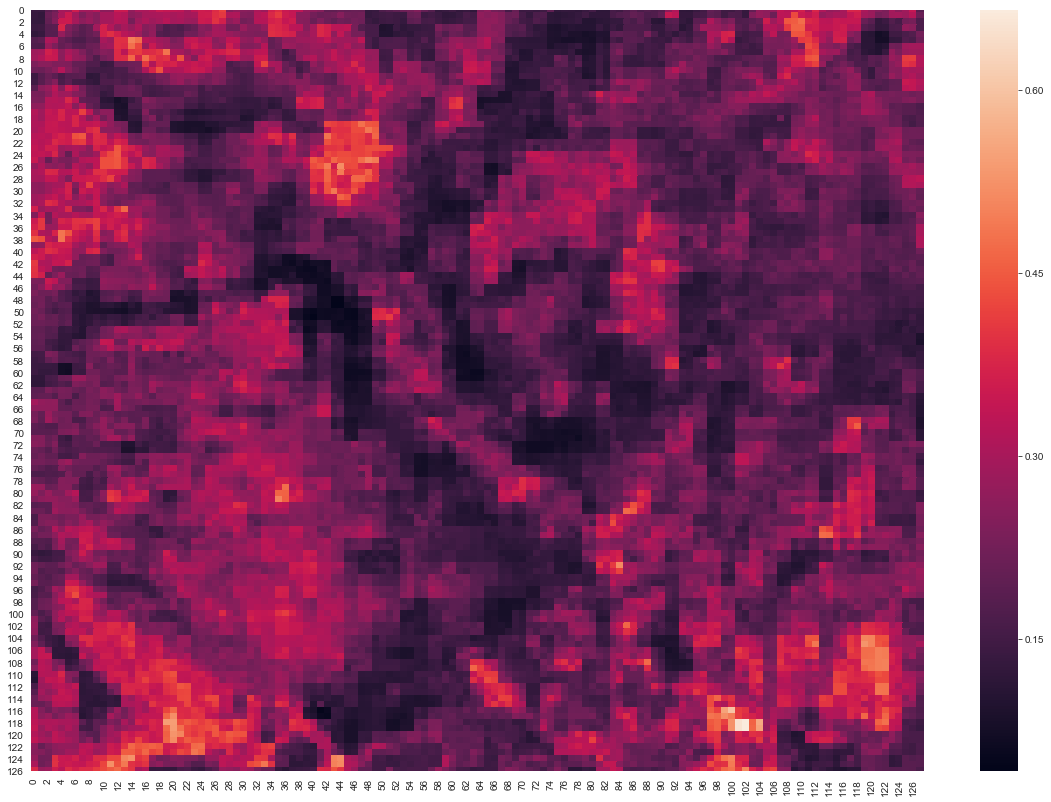

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(20, 14))
sns.heatmap(x2[1][38, :, :]) # 22, 27, 29, 

In [15]:
import logging
START_Y = 0
START_X = 0

import multiprocessing
for i in corner_coordinates[:8]:
    try:
        threads = 3
        pool = multiprocessing.Pool(threads)
        zip(*pool.map(worker_download, i[:12]))
        pool.close()
        pool.join()
    except Exception as e:
        print("error")
        logging.fatal(e, exc_info=True)

Starting: 1 0
Starting: 0 0
Starting: 2 0
[]
[]
1
[]
0
2
Original size: (135, 128, 128, 6)
Original size: (135, 128, 128, 6)
Original size: (135, 128, 128, 6)
Original 10 size: (135, 128, 128, 5)
Data shape: (135, 128, 128)
Downloaded imagery
There are 35/135 dirty steps: 32 cloud, 15 missing, 5 shadows
Removing 0 steps based on ratio
Original 10 size: (135, 128, 128, 5)
Original 10 size: (135, 128, 128, 5)
Data shape: (135, 128, 128)
Downloaded imagery
There are 28/135 dirty steps: 26 cloud, 10 missing, 1 shadows
Data shape: (135, 128, 128)
Downloaded imagery
There are 30/135 dirty steps: 28 cloud, 8 missing, 1 shadows
Removing 1 steps based on ratio
Removing 1 steps based on ratio
Removed 242970.53125 fake shadows, leaving 17795.693359375
The total percent shadow cover is: 0.010861629247665405%
Removed 511040.0 fake shadows, leaving 23104.0
The total percent shadow cover is: 0.013303360849056603%
Removed 9088.0 fake shadows, leaving 5376.0
The total percent shadow cover is: 0.0031550

KeyboardInterrupt: 